# Final full idea put together



joints to work with:
        # Define connections between joints
        connections = [
            ("R_EYE", "L_EYE"), ("R_EYE", "NOSE"), ("L_EYE", "NOSE"),
            ("R_EYE", "R_EAR"), ("L_EYE", "L_EAR"), ("R_SHOULDER", "L_SHOULDER"),
            ("R_SHOULDER", "R_ELBOW"), ("L_SHOULDER", "L_ELBOW"), ("R_ELBOW", "R_WRIST"),
            ("L_ELBOW", "L_WRIST"), ("R_SHOULDER", "R_HIP"), ("L_SHOULDER", "L_HIP"),
            ("R_HIP", "L_HIP"), ("R_HIP", "R_KNEE"), ("L_HIP", "L_KNEE"),
            ("R_KNEE", "R_ANKLE"), ("L_KNEE", "L_ANKLE"), ("R_WRIST", "R_1STFINGER"),
            ("R_WRIST", "R_5THFINGER"), ("L_WRIST", "L_1STFINGER"), ("L_WRIST", "L_5THFINGER"),
            ("R_ANKLE", "R_1STTOE"), ("R_ANKLE", "R_5THTOE"), ("L_ANKLE", "L_1STTOE"),
            ("L_ANKLE", "L_5THTOE"), ("R_ANKLE", "R_CALC"), ("L_ANKLE", "L_CALC"),
            ("R_1STTOE", "R_5THTOE"), ("L_1STTOE", "L_5THTOE"), ("R_1STTOE", "R_CALC"),
            ("L_1STTOE", "L_CALC"), ("R_5THTOE", "R_CALC"), ("L_5THTOE", "L_CALC"),
            ("R_1STFINGER", "R_5THFINGER"), ("L_1STFINGER", "L_5THFINGER")
        ]

ADDITIONS:
#, '1sttoe', '5thtoe' < ADD WHEN WE ADD TO DATA LOAD AND PREPARE IN MODULE %%writefile ml/feature_engineering/energy_exhaustion_metrics.py

look into why 
INFO: Angle column 'L_KNEE_angle' not found; skipping ROM metrics for L KNEE.
INFO: Angle column 'R_KNEE_angle' not found; skipping ROM metrics for R KNEE.


Below is a step‐by‐step walkthrough of how you can modify your existing pipeline to update the predictor variables, integrate additional metrics (asymmetry for all joints, power ratios, and ROM-based features), and then evaluate their importance relative to the target outcomes (exhaustion and injury risk). I’ve included plenty of breathing space between steps so you can follow along.

---

## Step 1: Review and Update Predictor Variables

**What We’re Changing:**

1. **Asymmetry Metrics:**  
   - **Before:** You had asymmetry for a few joints (e.g., elbows, knees).  
   - **Now:** Include asymmetry for wrists, shoulders, hips, ankles, feet—and, if data permits, compare left versus right sides of the feet (for landing and usage comparisons).  
   - **How:** For each paired joint (e.g., left/right shoulder), compute:
     ```python
     data['shoulder_asymmetry'] = np.abs(data['L_SHOULDER_energy'] - data['R_SHOULDER_energy'])
     ```
     Repeat for wrists, hips, ankles, and feet. For feet, if you have sub-foot measurements (e.g., left forefoot vs. right forefoot), compute those asymmetries as well.

2. **Power Ratios for All Joints:**  
   - **Before:** You had an ankle power ratio.  
   - **Now:** Compute power ratios for every joint pair.  
   - **How:** For example, for the shoulder:
     ```python
     data['shoulder_power_ratio'] = data['L_SHOULDER_power'] / (data['R_SHOULDER_power'] + 1e-6)
     ```
     Do similar computations for wrists, hips, knees, ankles, and feet.

3. **Range-of-Motion (ROM) Metrics:**  
   - **Before:** Your pipeline computed ROM for some joints and flagged extremes using deviation scores and binary flags.  
   - **Now:** For every joint you’re interested in (e.g., knee, shoulder, hip, etc.), compute:
     - The ROM:  
       ```python
       data['knee_ROM'] = data.groupby('trial_id')['knee_angle'].transform(lambda x: x.max() - x.min())
       ```
     - The deviation score relative to normative thresholds (e.g., using CDC normative values):  
       ```python
       normal_min_knee, normal_max_knee = 120, 135  # example values
       data['knee_ROM_deviation'] = np.maximum(0, normal_min_knee - data['knee_ROM']) + np.maximum(0, data['knee_ROM'] - normal_max_knee)
       ```
     - The binary flag indicating an extreme value:  
       ```python
       data['knee_ROM_extreme'] = ((data['knee_ROM'] < normal_min_knee) | (data['knee_ROM'] > normal_max_knee)).astype(int)
       ```
     - **Tip:** Repeat similar calculations for the shoulders, hips, ankles, and (if applicable) wrists.  
     
4. **Removing Non-Contributing Features:**  
   - You mentioned that the wrist angle at release is not useful for this model.  
   - **Action:** Remove or exclude this feature from your predictors:
     ```python
     predictors = [col for col in predictors if col != 'wrist_angle_release']
     ```

Take a breath—now we have updated the individual metrics.

---

## Step 2: Integrate Additional Metrics into the Feature Engineering Pipeline

### 2.1. Expand Asymmetry Calculations

For each joint pair, calculate asymmetry. For instance:
- **Shoulders, Hips, Ankles, Wrists, and Feet:**
  ```python
  for joint in ['shoulder', 'hip', 'ankle', 'wrist']:
      data[f'{joint}_asymmetry'] = np.abs(data[f'L_{joint.upper()}_energy'] - data[f'R_{joint.upper()}_energy'])
  # If foot sub-measurements exist:
  data['foot_asymmetry'] = np.abs(data['left_foot_energy'] - data['right_foot_energy'])
  ```
  
### 2.2. Compute Power Ratios Across All Joints

Similarly, loop over each joint to calculate a power ratio:
  ```python
  for joint in ['shoulder', 'hip', 'knee', 'ankle', 'wrist']:
      data[f'{joint}_power_ratio'] = data[f'L_{joint.upper()}_power'] / (data[f'R_{joint.upper()}_power'] + 1e-6)
  # For feet, if you have sub-joint or left/right foot power:
  data['foot_power_ratio'] = data['left_foot_power'] / (data['right_foot_power'] + 1e-6)
  ```

### 2.3. Incorporate Expanded ROM Metrics

For each joint (e.g., knee, shoulder, hip, ankle), compute ROM, deviation scores, and binary flags. Example for the knee was given above; repeat for each joint:
  ```python
  # Example for the shoulder (adjust normative thresholds accordingly)
  normal_min_shoulder, normal_max_shoulder = 0, 150  # example values for abduction
  data['shoulder_ROM'] = data.groupby('trial_id')['shoulder_angle'].transform(lambda x: x.max() - x.min())
  data['shoulder_ROM_deviation'] = np.maximum(0, normal_min_shoulder - data['shoulder_ROM']) + np.maximum(0, data['shoulder_ROM'] - normal_max_shoulder)
  data['shoulder_ROM_extreme'] = ((data['shoulder_ROM'] < normal_min_shoulder) | (data['shoulder_ROM'] > normal_max_shoulder)).astype(int)
  ```

### 2.4. Remove the Wrist Angle at Release

Before proceeding to the model training phase, ensure you drop or ignore the `wrist_angle_release` feature:
  ```python
  if 'wrist_angle_release' in data.columns:
      data.drop(columns=['wrist_angle_release'], inplace=True)
  ```

Let’s take another breath—now we have a fully enriched set of predictor variables.

---

## Step 3: Define Predictor (X) and Target (y) Variables for Each Model

### 3.1. Exhaustion Prediction

- **Target Variable (y):**  
  - `by_trial_exhaustion_score` (continuous measure)
  logic:
  trial time is every .33 seconds
    data['exhaustion_rate'] = data['by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()

- **Predictor Variables (X) should now include:**  
  - **Aggregated energy and power metrics:** joint_power, joint_energy  
  - **Asymmetry metrics:** elbow_asymmetry, knee_asymmetry, shoulder_asymmetry, hip_asymmetry, ankle_asymmetry, wrist_asymmetry, foot_asymmetry  
  - **Power ratios:** shoulder_power_ratio, hip_power_ratio, knee_power_ratio, ankle_power_ratio, wrist_power_ratio, foot_power_ratio  
  - **Lagged and rolling features:** exhaustion_lag1, power_avg_5, rolling_energy_std  
  - **Simulated physiological proxies:** simulated_HR, energy_acceleration  
  - **Anthropometrics:** player_height_in_meters, player_weight_in_kg  
  - **ROM-based features:** For each joint, include ROM, deviation scores (e.g., knee_ROM_deviation), and binary extreme flags (e.g., knee_ROM_extreme)

### 3.2. Injury Risk Prediction

- **Target Variable (y):**  
  - `injury_risk` (binary: 0 for low risk, 1 for high risk)
  logic:
    data['rolling_exhaustion'] = data['by_trial_exhaustion_score'].rolling(window=rolling_window).sum()
    data['injury_risk'] = np.where(data['rolling_exhaustion'] > quantile_75, 1, 0)

- **Predictor Variables (X) should include:**  
  - Many of the same metrics as exhaustion prediction but with an added emphasis on movement asymmetries and ROM abnormalities:
    - joint_power, joint_energy  
    - All asymmetry metrics  
    - All power ratios  
    - Lagged features like exhaustion_lag1  
    - Rolling averages (power_avg_5) and simulated_HR  
    - Anthropometrics  
    - **ROM Metrics:** All computed ROM values, deviation scores, and binary flags for each joint

### 3.2. Injury Risk Prediction

- **Target Variable (y):**  
  - knee, shoulder, ankle, and wrist `injury_risk` (binary: 0 for low risk, 1 for high risk)
  logic:
    data['{joint}_exhaustion_rate'] = data['{joint}_by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()
    data['{joint}_rolling_exhaustion'] = data['{joint}_by_trial_exhaustion_score'].rolling(window=rolling_window).sum()
    data['{joint}_injury_risk'] = np.where(data['{joint}_rolling_exhaustion'] > quantile_75, 1, 0)

- **Predictor Variables (X) should include:**  
  - Many of the same metrics as exhaustion prediction but with an added emphasis on movement asymmetries and ROM abnormalities:
    - joint_power, joint_energy  
    - All asymmetry metrics  
    - All power ratios  
    - Lagged features like exhaustion_lag1  
    - Rolling averages (power_avg_5) and simulated_HR  
    - Anthropometrics  
    - **ROM Metrics:** All computed ROM values, deviation scores, and binary flags for each joint
Take a breath—you now have a robust and enriched feature set for both exhaustion and injury risk predictions.

---

## Step 4: Train Models and Evaluate Feature Importance

### 4.1. Model Building

- **Exhaustion Prediction Model (Regression):**  
  Build an LSTM or any other regression model using the enriched feature set.
- **Injury Risk Prediction Model (Classification):**  
  Similarly, train a classification model using your combined features.

### 4.2. Evaluating Feature Importance

Once the models are trained, determine the relative importance of each feature using methods such as:

1. **Permutation Importance:**  
   Shuffle each predictor and measure the drop in performance.
   ```python
   from sklearn.inspection import permutation_importance
   results = permutation_importance(trained_model, X_test, y_test, scoring='neg_mean_absolute_error')
   importance_df = pd.DataFrame({'feature': X_test.columns, 'importance': results.importances_mean})
   ```

2. **Tree-based Methods:**  
   If you are using a random forest or gradient boosting method, use built-in feature importance metrics.
   ```python
   importance_df = pd.DataFrame({
       'feature': X_test.columns,
       'importance': trained_model.feature_importances_
   })
   ```

3. **SHAP Analysis:**  
   SHAP values can help you understand the impact of each feature on individual predictions.
   ```python
   import shap
   explainer = shap.TreeExplainer(trained_model)
   shap_values = explainer.shap_values(X_test)
   shap.summary_plot(shap_values, X_test)
   ```

4. **Correlation Analysis:**  
   Compute Pearson or Spearman correlation coefficients between each predictor and the target variable for a first-pass indication.

After evaluating, you can identify which features—be it asymmetry metrics, power ratios, or ROM-based measures—are most predictive of exhaustion or injury risk.

Take one final breath—your integrated pipeline now not only includes all the desired metrics but also has a clear process to assess which features are most influential in predicting the target outcomes.

---

## Final Recap

- **Updated Features:**  
  We added asymmetry calculations for all major joints (wrists, shoulders, hips, ankles, feet), computed power ratios for each joint pair, and expanded our ROM analysis to include deviation scores and binary flags.
  
- **Feature Removal:**  
  The wrist angle at release was removed as it was not helpful for the prediction task.
  
- **Integration:**  
  All these features were added to both the exhaustion and injury risk predictor sets.
  
- **Evaluation:**  
  We then laid out steps to train models and perform feature importance analyses (using permutation importance, tree-based methods, and SHAP).

By following these steps, you ensure that your workout simulation model incorporates comprehensive biomechanical metrics, enhancing the predictive power for both fatigue (exhaustion) and joint injury risk.




# Notes

Based on the CDC resource (see citeturn1search28 and the archived CDC page at https://archive.cdc.gov/www_cdc_gov/ncbddd/jointrom/index.html), here is an example of normative thresholds for joint range of motion in adults. (Note that these numbers are approximate—actual values may vary slightly by population and measurement method.)

- **Shoulder:**  
  - Flexion: Approximately 0° to 180°  
  - Abduction: Approximately 0° to 150°

- **Elbow:**  
  - Flexion: Approximately 0° to 150°  
  - Extension: 0° (full extension)

- **Wrist:**  
  - Flexion: Approximately 0° to 80°  
  - Extension: Approximately 0° to 70°

- **Hip:**  
  - Flexion: Approximately 0° to 120°  
  - Extension: Approximately 0° to 30°

- **Knee:**  
  - Flexion: Approximately 0° to 135°  
  - Extension: 0° (full extension)

- **Ankle:**  
  - Dorsiflexion: Approximately 0° to 20°  
  - Plantarflexion: Approximately 0° to 50°

### How These Thresholds Would Work in the Pipeline

1. **Data Extraction:**  
   After loading your granular data, you’ll extract joint angle data for each joint over each free throw. For example, if you have a column named “knee_angle,” you can calculate its maximum and minimum value during each trial.

2. **ROM Calculation:**  
   For each joint, compute the range of motion as:  
   \[
   \text{ROM} = \max(\text{joint\_angle}) - \min(\text{joint\_angle})
   \]
   This gives you the actual ROM for that trial.

3. **Comparison with Normative Thresholds:**  
   Using the thresholds above, you can then determine if the measured ROM is “extreme” (i.e., either below the lower bound or above the upper bound). For example, for the knee:
   - **Normal:** 0° to 135° of flexion  
   - **Abnormal/Extreme:** Less than 120° might be considered too stiff, while more than 135° (or above a clinically accepted maximum) could suggest hypermobility.
   
   You could flag these cases with:
   ```python
   normal_min_knee, normal_max_knee = 120, 135  # example thresholds
   data['knee_ROM'] = data.groupby('trial_id')['knee_angle'].transform(lambda x: x.max() - x.min())
   data['knee_ROM_extreme'] = ((data['knee_ROM'] < normal_min_knee) | (data['knee_ROM'] > normal_max_knee)).astype(int)
   ```
   Similar computations can be done for the shoulder, wrist, hip, and ankle.

4. **Using as Predictors:**  
   - For **injury risk prediction**, add these ROM metrics (or binary flags/deviation scores) to your feature set. The idea is that joints operating outside of their normative ranges may be at increased risk for injury.
   - For **exhaustion prediction**, while ROM might be a secondary predictor compared to energy and power, abnormal or highly variable ROM might still indicate inefficient or compensatory movement patterns that could correlate with fatigue.

5. **Integration with Other Metrics:**  
   Once these new ROM features are computed, they can be included alongside energy, power, and fatigue measures in both your exploratory analysis and predictive modeling steps. For instance, abnormal ROM in the shoulder (e.g., a flexion range below 170° or above 180°) might combine with high simulated heart rate or high energy acceleration to signal increased injury risk.

### Final Thoughts

Incorporating these threshold values from the CDC gives you objective criteria to flag when a joint’s range of motion is not within a healthy or expected range. When integrated into your pipeline, these metrics help provide a fuller picture of an athlete’s biomechanics—combining the magnitude of force (energy and power) with the quality of movement (ROM and its extremes). This approach can improve injury risk predictions and provide actionable insights for corrective interventions.

Sources:  
citeturn1search28 (Encyclopedia.com on Range of Motion) and the archived CDC page at https://archive.cdc.gov/www_cdc_gov/ncbddd/jointrom/index.html.

Below is an overview of the best ways to incorporate extreme range‐of‐motion (ROM) metrics into your workflow, along with a discussion of how these metrics can serve as an “injury index” by flagging movements that push joints toward their limits—potentially indicating over-stress in compromised positions.

---

### Incorporating Extreme ROM Metrics into the Workflow

#### 1. **Data Extraction & Calculation**

- **Extract Joint Angle Data:**  
  From your granular (frame-by-frame) dataset, extract the joint angle time series for each joint of interest (e.g., knee_angle, shoulder_angle, etc.) for each free throw or trial.

- **Compute the ROM for Each Joint:**  
  For each trial, calculate the range of motion as:  
  \[
  \text{ROM} = \max(\text{joint\_angle}) - \min(\text{joint\_angle})
  \]
  For example, if the knee angle varies between 30° and 140° in one trial, the ROM for that trial is 110°.

#### 2. **Comparison with Normative Thresholds**

Based on the CDC resource, you have normative thresholds for each joint. For instance:
  
- **Shoulder:**  
  - Flexion: 0° to 180°  
  - Abduction: 0° to 150°
  
- **Elbow:**  
  - Flexion: 0° to 150°  
  - Extension: 0° (full extension)
  
- **Wrist:**  
  - Flexion: 0° to 80°  
  - Extension: 0° to 70°
  
- **Hip:**  
  - Flexion: 0° to 120°  
  - Extension: 0° to 30°
  
- **Knee:**  
  - Flexion: 0° to 135°  
  - Extension: 0°
  
- **Ankle:**  
  - Dorsiflexion: 0° to 20°  
  - Plantarflexion: 0° to 50°

For each joint, decide on “extreme” thresholds that may indicate over-stress. For example, for the knee, you might define:
- **Normal Knee Flexion:** 0° to 135°  
- **Abnormally Restricted (Stiff) Knee:** ROM less than 120°  
- **Abnormally Excessive (Hypermobile) Knee:** ROM greater than 135° (or above an accepted clinical maximum)

#### 3. **Creating ROM-Based Features**

- **Deviation Metrics:**  
  For each joint, calculate a deviation measure that quantifies how far the measured ROM deviates from the normative (or “optimal”) range. For example:
  ```python
  # For the knee, using illustrative thresholds
  normal_min_knee, normal_max_knee = 120, 135
  data['knee_ROM'] = data.groupby('trial_id')['knee_angle'].transform(lambda x: x.max() - x.min())
  data['knee_ROM_deviation'] = np.maximum(0, normal_min_knee - data['knee_ROM']) + np.maximum(0, data['knee_ROM'] - normal_max_knee)
  ```
  This continuous deviation score provides a “meter” of how far the joint is operating outside the normal range.

- **Binary Flags:**  
  Alternatively, create binary flags that indicate whether a joint’s ROM is extreme:
  ```python
  data['knee_ROM_extreme'] = ((data['knee_ROM'] < normal_min_knee) | (data['knee_ROM'] > normal_max_knee)).astype(int)
  ```
  These flags can be used directly in your injury risk prediction models.

#### 4. **Integrating into the Injury Index**

- **Weighted Injury Index:**  
  Combine the deviation scores (or binary flags) from multiple joints into an aggregated “injury index.” For instance, you might take a weighted sum of the deviation scores for key joints (e.g., knee, shoulder, hip) based on their importance in your analysis:
  ```python
  data['injury_index'] = (w1 * data['knee_ROM_deviation'] + 
                          w2 * data['shoulder_ROM_deviation'] + 
                          w3 * data['hip_ROM_deviation'])
  ```
  where *w1*, *w2*, and *w3* are weights determined either by domain expertise or through feature importance analysis.

- **Interpretation:**  
  The injury index provides a quantitative measure of how “compromised” a joint (or combination of joints) is by operating at extreme ranges. A higher index suggests that the athlete’s joints are spending more time (or exhibiting more variability) near their extremes, which could be a sign of over-stress and a higher risk for injury.

#### 5. **Integration with Other Metrics and Modeling**

- **As Predictors:**  
  Add these ROM-derived metrics (both continuous deviations and binary flags) to your predictor set (X) in the injury risk model. They can be used alongside existing metrics like joint_energy, energy_acceleration, and simulated_HR.
  
- **Model Analysis:**  
  Run feature importance or SHAP analysis on the injury risk model to see how strongly these ROM features contribute to predicting injury. If they are significant, it confirms that operating in extreme ROM is an important risk factor.

- **Dynamic Feedback:**  
  In a real-time or near-real-time monitoring system, these ROM metrics could provide immediate feedback. For example, if an athlete’s knee ROM suddenly deviates from the norm, the system could alert coaches or trigger a warning to adjust the training load.

---

### Final Thoughts

By incorporating extreme range-of-motion metrics, your workflow gains a new dimension that quantifies not only the volume of joint movement (energy and power) but also its quality. This allows you to:
- **Detect Abnormal Movement Patterns:** Identify when joints are operating at the edge of their healthy range.
- **Quantify Over-Stress:** Create an injury index that reflects cumulative stress from abnormal ROM.
- **Enhance Predictive Models:** Integrate these metrics into both exhaustion and injury risk prediction, potentially increasing model accuracy.
- **Support Preventive Interventions:** Use the injury index as a real-time tool to flag potentially compromised movements, guiding corrective actions or modifications in training.

In summary, incorporating extreme ROM metrics (using the thresholds from the CDC resource) into your pipeline could indeed provide a valuable “meter” that measures the degree of flexion towards the extremes. This, in turn, serves as an injury index that captures over-stress in compromised positions—enhancing your ability to predict and ultimately prevent injuries.


Below is a discussion of how you might add abnormal joint ROM patterns and additional metrics—ultimately building an “injury index”—into your workflow. This discussion expands on the concept using the normative thresholds from the CDC resource and explains step by step how these extra metrics can be computed, integrated, and used to flag over-stress or compromised positions that might increase injury risk.

---

### 1. Concept Overview

Our goal is to enhance the existing biomechanical pipeline by adding range-of-motion (ROM) metrics that capture not only whether a joint is moving but whether it is operating within a healthy, normative range. Using the CDC thresholds as guidelines (for example, shoulder flexion is normally 0°–180°, knee flexion is normally 0°–135°, etc.), we can flag instances where a joint’s ROM is either too restricted or too excessive. These abnormal values may indicate:
  
- **Stiffness or limited mobility:** Suggesting potential overuse, injury, or compensatory movement patterns.
- **Hypermobility:** Which might also lead to instability and increase the risk of injury.

By quantifying how far a joint’s ROM deviates from the normative range, we can create additional features that serve as predictors. When combined with energy, power, and fatigue metrics, these ROM-derived metrics could help form an “injury index” that measures the cumulative stress on an athlete’s joints.

---

### 2. Calculating Abnormal ROM Metrics

**Step A. Data Extraction & ROM Calculation**

- **Extract Joint Angle Data:**  
  For each trial (or free throw), extract the time series for each joint’s angle. For instance, for the knee, use the column `knee_angle`.

- **Compute ROM:**  
  Calculate the ROM per trial as:
  \[
  \text{ROM} = \max(\text{joint\_angle}) - \min(\text{joint\_angle})
  \]
  For example, if during a trial, `knee_angle` varies between 30° and 140°, the ROM is 110°.

**Step B. Compare with Normative Thresholds**

Using the CDC resource, we have normative ranges—for instance:
  
- **Knee:**  
  - Normal flexion: 0° to 135°
  - Abnormal/Extreme: A ROM below 120° might be too restricted (stiff), and above 135° could suggest hypermobility.

You would then:
  
- **Compute Deviation Metrics:**  
  Determine how far the measured ROM is from the “ideal” range. For the knee:
  ```python
  normal_min_knee, normal_max_knee = 120, 135  # Example thresholds
  data['knee_ROM'] = data.groupby('trial_id')['knee_angle'].transform(lambda x: x.max() - x.min())
  data['knee_ROM_deviation'] = np.maximum(0, normal_min_knee - data['knee_ROM']) + np.maximum(0, data['knee_ROM'] - normal_max_knee)
  ```
  This continuous deviation score indicates how far the knee is from its optimal ROM.

- **Create Binary Flags:**  
  Alternatively, or additionally, create a flag to indicate if the ROM is extreme:
  ```python
  data['knee_ROM_extreme'] = ((data['knee_ROM'] < normal_min_knee) | (data['knee_ROM'] > normal_max_knee)).astype(int)
  ```

Similar calculations would be applied to other joints (shoulder, elbow, wrist, hip, ankle) using their respective normative ranges.

---

### 3. Building an Injury Index

Once you have the abnormal ROM metrics for key joints, you can combine these to form an overall “injury index.” This index quantifies how much an athlete’s joints are operating outside of their healthy ranges:

- **Weighted Sum or Composite Score:**  
  For example, if you have deviation scores for the knee, shoulder, and hip, you might compute:
  ```python
  data['injury_index'] = (w1 * data['knee_ROM_deviation'] + 
                          w2 * data['shoulder_ROM_deviation'] + 
                          w3 * data['hip_ROM_deviation'])
  ```
  Here, *w1*, *w2*, and *w3* are weights you can set based on domain expertise or derived from feature importance analysis. Alternatively, you could sum the binary flags to get a count of joints with abnormal ROM.

- **Interpreting the Index:**  
  A higher injury index means that, across multiple joints, the athlete is operating further outside normative ranges. This could signal that the body is under stress or that certain joints are compensating—both of which are risk factors for injury.

---

### 4. Integrating into the Workflow

#### **A. During Data Preparation and Feature Engineering:**

- **Calculate ROM Metrics:**  
  Add a routine in your joint feature preparation step that calculates the ROM for each joint, compares it to normative thresholds, and computes both deviation scores and binary flags.

- **Include in Feature Set:**  
  Integrate these ROM metrics alongside your existing features (joint_energy, joint_power, energy_acceleration, simulated_HR, etc.). This way, when you perform lagged and rolling calculations, the ROM data is also available for analysis.

#### **B. In Predictive Modeling:**

- **Injury Risk Prediction Model:**  
  Add the abnormal ROM metrics (e.g., knee_ROM_deviation, knee_ROM_extreme, etc.) as additional predictors (X). The hypothesis is that if an athlete’s ROM is frequently outside the normative range, this could indicate increased injury risk.

- **Exhaustion Prediction Model:**  
  While ROM might be less directly linked to exhaustion, abnormal or highly variable ROM might also indicate inefficiencies in movement that contribute to fatigue. Thus, these metrics can serve as secondary predictors.

- **Analysis & Interpretation:**  
  Use feature importance analyses (e.g., SHAP values) to assess how these new ROM features contribute to predicting injury risk. If they emerge as significant predictors, they can guide further intervention strategies.

#### **C. Real-Time Monitoring and Feedback:**

- **Dynamic Injury Index:**  
  In a real-time monitoring system, compute the injury index on the fly during a free throw or training session. If the index exceeds a critical threshold, the system can alert coaches or trainers to adjust the athlete’s workload or technique.

- **Longitudinal Monitoring:**  
  Track changes in the injury index over time. If an athlete’s index begins to increase, it may indicate deteriorating joint function or increased stress—prompting early intervention.

---

### 5. Final Thoughts on Implementation

By incorporating these abnormal ROM metrics into your workflow, you create an additional “meter” that quantifies how far an athlete’s joint movements deviate from healthy norms. This injury index, derived from a combination of deviation scores or binary flags from key joints, serves several purposes:

- **Enhanced Prediction:**  
  It improves injury risk models by adding information on movement quality and joint health.

- **Preventive Insight:**  
  It allows for early detection of abnormal movement patterns, enabling timely corrective interventions.

- **Holistic View:**  
  Combined with energy, power, and fatigue metrics, it provides a comprehensive picture of an athlete’s biomechanical function.

Integrating these features into your existing pipeline means that your data preparation, feature engineering, and modeling processes will now capture not only the intensity of movement but also its quality—ultimately leading to better predictions and more actionable insights for injury prevention.

This approach, based on CDC normative thresholds, transforms raw joint angle data into meaningful metrics that inform both clinical assessments and real-time coaching interventions.

1. Data Loading and Merging

    Load the Raw Data:
        CSV Input:
        The main CSV file contains free throw data captured every 0.33 seconds across 125 trials. Each row represents a frame, providing highly granular time series information.
        JSON Input:
        Participant information (e.g., anthropometrics) is loaded from a JSON file.
    Merge the Data Sources:
        A participant ID is added as a new column in the CSV data.
        The CSV and JSON data are merged on the participant ID.
    Debugging and Logging:
        After the merge, the pipeline logs the new dataset shape and prints sample column values to ensure the merge was successful.

2. Preparing Joint Features

    Renaming and Cleaning:
        Rename columns for clarity (for example, height_in_meters is renamed to player_height_in_meters and weight__in_kg becomes player_weight__in_kg).
    Aggregating Joint Data:
        Identify Columns:
        All columns related to joint energy (e.g., columns with “_energy”) and ongoing power (e.g., columns with “_power”) are identified.
        Create Aggregated Features:
            joint_energy:
            The sum of all individual joint energy columns.
            joint_power:
            The sum of all individual joint power columns.
    New Feature Creation:
        Energy Acceleration:
        Compute the change in joint_energy divided by the change in continuous_frame_time (i.e., the derivative) to capture instantaneous energy acceleration.
        Implementation Example:

energy_acceleration = diff(joint_energy) / diff(continuous_frame_time)

Ankle Power Ratio:
Calculate the ratio between left and right ankle ongoing power (with a small constant in the denominator for numerical stability).
Implementation Example:

        ankle_power_ratio = L_ANKLE_power / (R_ANKLE_power + 1e-6)

    Ordering and Sorting:
        Data is sorted by participant_id and continuous_frame_time to maintain the correct temporal order.
    Asymmetry Calculation:
        Compute asymmetry features such as elbow_asymmetry and knee_asymmetry by taking the absolute difference between the left and right joint energy measurements.
    Exhaustion and Simulated Heart Rate:
        exhaustion_rate:
        Computed as the change in the exhaustion score over time.
        simulated_HR:
        A synthetic heart rate generated based on the exhaustion score and joint energy values.

3. Feature Engineering

    Lagged and Rolling Features:
        Lagged Features:
        Create a one-step lag for the exhaustion score to capture temporal dependencies.
        Rolling Averages and Standard Deviations:
        Calculate rolling statistics for features such as joint_power and now also joint_energy (using a fixed window, e.g., 5 frames).
        Optional New Feature – Rolling Energy Standard Deviation:
        Compute the rolling standard deviation of joint_energy to capture its short-term variability.
    Temporal Calculations:
        Time Since Start:
        Compute the elapsed time since the beginning of the session using the continuous_frame_time column.
        Exponential Moving Average:
        Smooth the exhaustion score using an exponential moving average.
    Injury Risk Simulation:
        A binary injury risk label is derived by comparing the rolling sum of the exhaustion score (calculated over a longer window, e.g., 20 frames) against the 75th percentile.
    Handling Missing Values:
        Any rows with missing data (which may result from shifting or rolling operations) are dropped.

4. Simulated Player Metrics

    Additional Simulated Features:
        Alternative Simulated Heart Rate (simulated_HR_fake):
        Uses a different formula based on exhaustion and normalized joint energy.
        Fatigue Index and Rate:
        Compute a synthetic fatigue index and its frame-to-frame rate of change.
        HR Variability:
        Calculate the rolling standard deviation of the simulated heart rate.
    Purpose:
    These additional metrics help provide extra insight into player fatigue and can be cross-validated with the primary metrics.

5. Analysis Functions

The pipeline includes multiple analysis functions to explore different aspects of the free throw and movement data:

    Joint-Specific Analysis:
        Energy Distributions:
        Boxplots are generated to view the energy distribution for each joint.
        Injury Risk:
        Joint-specific injury risk is analyzed by comparing joint energies across groups with low and high injury risk.
        Cumulative Energy Patterns:
        Energy accumulation over time is visualized using cumulative sum plots.
    Movement Pattern Analysis:
        Angular Velocity Histograms:
        Density plots (with KDE) are created for any angular velocity features.
        Asymmetry Relationships:
        Pairplots are generated to display relationships among asymmetry metrics alongside injury risk.
    Temporal Analysis:
        Lagged Correlations:
        Lagged correlations between joint_energy and the exhaustion score are computed to examine temporal dependencies.
        Autocorrelation Plots:
        Autocorrelation of joint_energy is visualized to understand repeating patterns over time.
    Multivariate Analysis:
        3D Visualizations:
        Separate 3D scatter plots are created for left- and right-sided joint energies, with colors indicating injury risk.
        Clustering:
        KMeans clustering is applied on subsets of features to identify distinct movement patterns.
    Statistical Testing:
        Mann–Whitney U Tests:
        For each joint energy column, a nonparametric test compares groups with low and high injury risk.
    Fatigue–Injury Interaction Analysis:
        Fatigue-Injury Matrix:
        A heatmap visualizes the relationship between binned exhaustion scores and joint energy.
        SHAP Interaction Analysis:
        A Random Forest model is used to study interaction effects (for example, combining player height and joint energy) using SHAP values.

6. Preprocessing and LSTM Setup

    Temporal Train–Test Split:
        The data is split based on time (with earlier frames for training and later frames for testing) to preserve temporal order.
    Feature Scaling:
        Features are scaled using a standard scaler to enable efficient convergence of the LSTM model.
    Sequence Creation:
        The data is restructured into sequences (e.g., groups of 5 consecutive frames) to feed into the LSTM model, preserving the free throw motion’s time dependencies.

7. Model Building, Training, and Evaluation

    LSTM Model Architecture:
        Enhanced Architecture:
        The model includes two LSTM layers with dropout regularization, followed by a dense hidden layer.
        Output Layer Choice:
            For regression (predicting the exhaustion score), a linear output is used.
            For classification (predicting injury risk), a sigmoid activation is applied.
    Training Process:
        The model is trained with early stopping based on validation loss to avoid overfitting.
        Training is performed using the sequences generated from the scaled data.
    Evaluation:
        Regression Metrics:
        Mean Absolute Error (MAE) and R² are computed.
        Classification Metrics:
        Accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix visualizations are provided.
    Visualization:
        Predictions over time are plotted against the actual values to visualize model performance.
        Injury risk probabilities are plotted alongside actual injury events to provide further insight.

Future Improvements

    Pre-Workout Baseline Evaluation:
    The next iteration of the pipeline will include evaluating the player's activity and energy levels from the day before the workout. This baseline metric will be captured and stored for comparison.
    Dynamic Monitoring During the Workout:
    Once the baseline is established, the same metric will be continuously monitored during the workout. The goal is to compare in-session activity against the baseline, thereby providing a real-time indicator of potential injury and fatigue.
    Integration with Real-Time Analytics:
    Future versions may incorporate real-time prediction and alerting systems that use the evolving metrics to flag abnormal fatigue or elevated injury risk, enabling preemptive interventions.
    Range of Motion Analysis:
    As an additional future improvement, incorporate analysis of joint range-of-motion:
        Identify Unusual Ranges:
        Calculate and monitor the range (maximum–minimum) for each joint’s movement during the free throw.
        Use as a Predictor:
        Unusual joint ranges (outside of typical values) can be flagged as potential risk factors and used as predictors for injury. This metric could help in understanding the impact on each joint and may offer additional insight when combined with energy and fatigue metrics.


8. Predictor and Target Variables (X and y)

In our pipeline, we build two separate predictive models: one for forecasting the exhaustion score and one for predicting injury risk. Understanding which variables serve as inputs (predictors) and which are our outcomes (targets) is essential to interpret our modeling strategy and its results.
8.1 Exhaustion Prediction

Target Variable (y):

    by_trial_exhaustion_score
        Definition: This continuous numeric variable represents the exhaustion level measured (or computed) for each trial.
        Role: It is the outcome we aim to predict using regression. Higher scores typically indicate a greater degree of fatigue.

Predictor Variables (X):
The following features are used to predict the exhaustion score:

    joint_power
        Definition: The aggregated sum of all instantaneous joint power measurements.
        Rationale: Represents overall power output during the free throw motion.
    joint_energy
        Definition: The aggregated sum of energy values across joints.
        Rationale: Reflects the total energy expenditure during the motion.
    elbow_asymmetry
        Definition: The absolute difference between the left and right elbow energy values.
        Rationale: Imbalances in elbow function may correlate with overall fatigue.
    wrist_angle
        Definition: The angle of the wrist at ball release.
        Rationale: Captures the kinematic aspect of the throw which may be related to fatigue.
    exhaustion_lag1
        Definition: The one-frame lag of the exhaustion score.
        Rationale: Incorporates temporal dependencies, allowing the model to understand recent fatigue trends.
    power_avg_5
        Definition: The rolling average of joint power computed over a fixed window (e.g., 5 frames).
        Rationale: Provides a smoothed measure of power output that reduces noise.
    simulated_HR
        Definition: A synthetic heart rate computed based on exhaustion and energy values.
        Rationale: Acts as a proxy for physiological stress or fatigue.
    player_height_in_meters and player_weight__in_kg
        Definition: Anthropometric measures of the player.
        Rationale: These may moderate the relationship between movement metrics and fatigue.
    (Additional features from preprocessing):
        Metrics such as energy_acceleration, ankle_power_ratio, and rolling_energy_std are also computed. Although they may not be included in the default feature lists, they are available for further exploration as predictors.
            energy_acceleration: Captures the rate of change of energy expenditure.
            ankle_power_ratio: Reflects lower-limb power symmetry.
            rolling_energy_std: Indicates variability in joint energy over short time spans.


Deep Dive Summary for Exhaustion:
The model uses these X features to learn how patterns in biomechanical output (power, energy, and asymmetries) and derived physiological proxies (simulated HR, rolling averages, etc.) relate to the player's level of fatigue. By including lagged features and rolling statistics, the model can capture temporal dynamics and smooth short-term fluctuations, ultimately predicting the exhaustion score for each trial.
8.2 Injury Risk Prediction

Target Variable (y):

    injury_risk
        Definition: A binary indicator where 0 denotes low injury risk and 1 indicates high injury risk.
        Role: It is the outcome for classification. The label is derived by comparing the rolling sum of exhaustion scores against a threshold (e.g., the 75th percentile), and it may later be enriched with additional predictors such as joint range-of-motion.

Predictor Variables (X):
The features used for injury risk prediction are similar to those for exhaustion but with some emphasis on metrics that capture asymmetries and imbalances:

    joint_power
        Definition: Overall power output.
    joint_energy
        Definition: Total energy expenditure.
    elbow_asymmetry
        Definition: Imbalance between left and right elbow energy.
    knee_asymmetry
        Definition: Imbalance between left and right knee energy.
    wrist_angle
        Definition: The wrist angle at ball release.
    exhaustion_lag1
        Definition: The previous frame’s exhaustion score, highlighting temporal trends.
    power_avg_5
        Definition: Rolling average of joint power.
    simulated_HR
        Definition: Synthetic heart rate based on the interplay between exhaustion and energy.
    player_height_in_meters and player_weight__in_kg
        Definition: Anthropometric information which may affect injury susceptibility.
    (Additional features for future work):
        Range of Motion Metrics:
            Definition: Calculated as the range (maximum – minimum) of each joint’s movement over a trial.
            Rationale: Unusual ranges (too high or too low) might indicate improper technique or joint stress, serving as a potential predictor for injury.
        Other Derived Metrics:
            Metrics such as energy_acceleration, ankle_power_ratio, and rolling_energy_std (as described above) can be incorporated to enhance the injury risk model by capturing sudden changes, asymmetries, or high variability in movement.

Deep Dive Summary for Injury Risk:
For injury risk prediction, the model leverages biomechanical and physiological metrics that may indicate improper movement patterns or excessive load. By combining aggregate measures (joint energy and power) with asymmetry features and potentially range-of-motion metrics, the model aims to identify when a player's movement deviates from typical patterns—deviations that may predispose them to injury. The inclusion of both static (anthropometrics) and dynamic (temporal and rolling features) data ensures that the prediction captures both inherent risk factors and situational stresses.
8.3 Summary: How X and y Variables Work Together

    Exhaustion Prediction:
        Y Variable: Continuous exhaustion score (by_trial_exhaustion_score).
        X Metrics: A combination of aggregated power and energy outputs, asymmetry measures, lagged and rolling statistics, and physiological proxies (simulated HR), along with anthropometrics.
    Injury Risk Prediction:
        Y Variable: Binary injury risk indicator (injury_risk).
        X Metrics: Similar to exhaustion but with an added focus on asymmetry (e.g., knee_asymmetry), plus potential future predictors like joint range-of-motion. These metrics capture both the immediate and cumulative stresses on the joints.

# Load Data

In [1]:
import numpy as np
import pandas as pd
import json
import sys
import logging
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import shap

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')


###############################################################################
# HELPER FUNCTION FOR DEBUG OUTPUTS
###############################################################################
def _print_debug_info(step_name, df, new_columns=None, debug=False):
    """
    Prints debug information about a DataFrame after a processing step.
    
    When debug=True, prints:
      - The step name.
      - The DataFrame shape.
      - If new_columns is provided (a list of column names), prints for each:
          • Data type and a sample of unique values (up to 5).
    When debug=False, prints a single-line message indicating step completion.
    """
    if debug:
        logging.info(f"Step [{step_name}]: DataFrame shape = {df.shape}")
        if new_columns:
            logging.info(f"New columns added: {new_columns}")
            for col in new_columns:
                sample = df[col].dropna().unique()[:5]
                logging.info(f" - {col}: dtype={df[col].dtype}, sample values={sample}")
    else:
        logging.info(f"Step [{step_name}] completed.")


###############################################################################
# FUNCTION DEFINITIONS
###############################################################################
def load_data(csv_path, json_path, participant_id='P0001', debug=False):
    """
    Loads the main dataset and participant information, then merges them.
    
    Parameters:
      - csv_path (str): Path to the main CSV file.
      - json_path (str): Path to the participant information JSON file.
      - participant_id (str): Participant identifier.
      - debug (bool): If True, prints detailed debug info.
    
    Returns:
      - data (pd.DataFrame): Merged DataFrame.
    """
    # Load main dataset
    try:
        data = pd.read_csv(csv_path)
        logging.info(f"Loaded data from {csv_path} with shape {data.shape}")
    except FileNotFoundError:
        logging.error(f"File not found: {csv_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {csv_path}: {e}")
        sys.exit(1)
    
    data['participant_id'] = participant_id
    logging.info(f"Added 'participant_id' column with value '{participant_id}'")
    
    # Load participant info
    try:
        with open(json_path, 'r') as file:
            participant_info = json.load(file)
        participant_df = pd.DataFrame([participant_info])
        logging.info(f"Loaded participant information from {json_path}")
    except FileNotFoundError:
        logging.error(f"File not found: {json_path}")
        sys.exit(1)
    except json.JSONDecodeError:
        logging.error(f"Invalid JSON format in {json_path}")
        sys.exit(1)
    except Exception as e:
        logging.error(f"Error loading {json_path}: {e}")
        sys.exit(1)
    
    data = pd.merge(data, participant_df, on='participant_id', how='left')
    logging.info(f"Merged participant data. New shape: {data.shape}")
    _print_debug_info("load_data", data, debug=debug)
    return data

def calculate_joint_angles(df, connections, debug=False):
    """
    Calculates joint angles from coordinate data using vector mathematics.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing joint coordinates.
        connections (list): Joint connections defining biomechanical segments.
        debug (bool): Enable debug logging.
        
    Returns:
        df (pd.DataFrame): Updated DataFrame with new angle columns.
    """
    angle_columns = []
    
    # Define angle calculation points for key joints
    # Note: The new "KNEE" definition uses hip, knee, and ankle as the points.
    angle_definitions = {
        'SHOULDER': {
            'left': ['L_HIP', 'L_SHOULDER', 'L_ELBOW'],
            'right': ['R_HIP', 'R_SHOULDER', 'R_ELBOW']
        },
        'HIP': {
            'left': ['L_SHOULDER', 'L_HIP', 'L_KNEE'],
            'right': ['R_SHOULDER', 'R_HIP', 'R_KNEE']
        },
        'KNEE': {
            'left': ['L_HIP', 'L_KNEE', 'L_ANKLE'],
            'right': ['R_HIP', 'R_KNEE', 'R_ANKLE']
        },
        'ANKLE': {
            'left': ['L_KNEE', 'L_ANKLE', 'L_5THTOE'],
            'right': ['R_KNEE', 'R_ANKLE', 'R_5THTOE']
        }
    }

    for joint, sides in angle_definitions.items():
        for side in ['left', 'right']:
            points = sides[side]
            prefix = 'L' if side == 'left' else 'R'
            
            # Build list of required coordinate columns for this calculation
            required_cols = []
            for point in points:
                required_cols += [f'{point}_x', f'{point}_y', f'{point}_z']
                
            if all(col in df.columns for col in required_cols):
                # Calculate the vectors needed for the angle
                vec1 = df[[f'{points[0]}_x', f'{points[0]}_y', f'{points[0]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values
                vec2 = df[[f'{points[2]}_x', f'{points[2]}_y', f'{points[2]}_z']].values - \
                       df[[f'{points[1]}_x', f'{points[1]}_y', f'{points[1]}_z']].values

                # Compute the dot product and the norms of the vectors
                dot_product = np.sum(vec1 * vec2, axis=1)
                norm_product = np.linalg.norm(vec1, axis=1) * np.linalg.norm(vec2, axis=1)
                
                # Compute the angle (in degrees) and add a small epsilon to avoid division by zero
                angles = np.degrees(np.arccos(dot_product / (norm_product + 1e-8)))
                
                col_name = f'{prefix}_{joint}_angle'
                df[col_name] = angles
                angle_columns.append(col_name)
                
                if debug:
                    logging.info(f"Calculated {col_name} with mean: {angles.mean():.2f}°")
            else:
                logging.warning(f"Missing coordinates for {prefix}_{joint} angle calculation")

    _print_debug_info("calculate_joint_angles", df, new_columns=angle_columns, debug=debug)
    return df



def prepare_joint_features(data, debug=False):
    """
    Aggregates joint-level energy and power, creates additional biomechanical features,
    and adds new features:
      - energy_acceleration: instantaneous rate of change of joint_energy.
      - ankle_power_ratio: ratio of left to right ankle ongoing power.
      - Additional asymmetry metrics for shoulders, hips, ankles, wrists, and feet.
      - Power ratios for all joint pairs.
      - Side-Specific Range-of-Motion (ROM) metrics (ROM, deviation, and binary extreme flag).
      - Removal of the wrist_angle_release column if present.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - data (pd.DataFrame): Updated DataFrame with new features.
    """
    step = "prepare_joint_features"
    new_cols = []
    connections = [
        ("R_EYE", "L_EYE"), ("R_EYE", "NOSE"), ("L_EYE", "NOSE"),
        ("R_EYE", "R_EAR"), ("L_EYE", "L_EAR"), ("R_SHOULDER", "L_SHOULDER"),
        ("R_SHOULDER", "R_ELBOW"), ("L_SHOULDER", "L_ELBOW"), ("R_ELBOW", "R_WRIST"),
        ("L_ELBOW", "L_WRIST"), ("R_SHOULDER", "R_HIP"), ("L_SHOULDER", "L_HIP"),
        ("R_HIP", "L_HIP"), ("R_HIP", "R_KNEE"), ("L_HIP", "L_KNEE"),
        ("R_KNEE", "R_ANKLE"), ("L_KNEE", "L_ANKLE"), ("R_WRIST", "R_1STFINGER"),
        ("R_WRIST", "R_5THFINGER"), ("L_WRIST", "L_1STFINGER"), ("L_WRIST", "L_5THFINGER"),
        ("R_ANKLE", "R_1STTOE"), ("R_ANKLE", "R_5THTOE"), ("L_ANKLE", "L_1STTOE"),
        ("L_ANKLE", "L_5THTOE"), ("R_ANKLE", "R_CALC"), ("L_ANKLE", "L_CALC"),
        ("R_1STTOE", "R_5THTOE"), ("L_1STTOE", "L_5THTOE"), ("R_1STTOE", "R_CALC"),
        ("L_1STTOE", "L_CALC"), ("R_5THTOE", "R_CALC"), ("L_5THTOE", "L_CALC"),
        ("R_1STFINGER", "R_5THFINGER"), ("L_1STFINGER", "L_5THFINGER")
    ]
    # Compute joint angles first.
    data = calculate_joint_angles(data, connections, debug=debug)
    
    # Rename participant anthropometrics if available.
    if 'height_in_meters' in data.columns and 'weight__in_kg' in data.columns:
        data['player_height_in_meters'] = data['height_in_meters']
        data['player_weight__in_kg'] = data['weight__in_kg']
        data.drop(['height_in_meters', 'weight__in_kg'], axis=1, inplace=True, errors='ignore')
        new_cols.extend(['player_height_in_meters', 'player_weight__in_kg'])
        logging.info("Renamed participant anthropometrics.")
    else:
        logging.warning("Participant anthropometric columns not found during renaming.")

    # Identify joint energy and power columns.
    joint_energy_columns = [col for col in data.columns if '_energy' in col and not ('by_trial' in col or 'overall' in col)]
    print("Joint energy columns: ", joint_energy_columns)
    joint_power_columns = [col for col in data.columns if '_ongoing_power' in col]
    print("Joint power columns: ", joint_power_columns)
    print("All angle columns: ", [col for col in data.columns if 'angle' in col])
    logging.info(f"Identified {len(joint_energy_columns)} joint energy and {len(joint_power_columns)} joint power columns.")
    if not joint_energy_columns:
        logging.error("No joint energy columns found. Check naming conventions.")
        sys.exit(1)
    if not joint_power_columns:
        logging.error("No joint power columns found. Check naming conventions.")
        sys.exit(1)
    
    # Create aggregated columns.
    data['joint_energy'] = data[joint_energy_columns].sum(axis=1)
    data['joint_power'] = data[joint_power_columns].sum(axis=1)
    new_cols.extend(['joint_energy', 'joint_power'])
    logging.info("Created aggregated 'joint_energy' and 'joint_power'.")

    # --- NEW FEATURE: Energy Acceleration ---
    if 'continuous_frame_time' in data.columns:
        time_diff = data['continuous_frame_time'].diff().replace(0, 1e-6)  # Avoid division by zero
        data['energy_acceleration'] = data['joint_energy'].diff() / time_diff
        data['energy_acceleration'] = data['energy_acceleration'].replace([np.inf, -np.inf], np.nan)
        new_cols.append('energy_acceleration')
        logging.info("Created 'energy_acceleration' as derivative of joint_energy over time.")
    else:
        logging.error("Missing 'continuous_frame_time' for energy_acceleration calculation.")
        sys.exit(1)
    
    # --- NEW FEATURE: Ankle Power Ratio ---
    # For power, look for the '_ongoing_power' suffix.
    if 'L_ANKLE_ongoing_power' in data.columns and 'R_ANKLE_ongoing_power' in data.columns:
        data['ankle_power_ratio'] = data['L_ANKLE_ongoing_power'] / (data['R_ANKLE_ongoing_power'] + 1e-6)
        new_cols.append('ankle_power_ratio')
        logging.info("Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.")
    else:
        logging.warning("Ankle ongoing power columns not found; 'ankle_power_ratio' not created.")

    # --- NEW FEATURES: Additional Asymmetry Metrics ---
    additional_asymmetry_joints = ['hip', 'ankle', 'wrist', 'elbow', 'knee', '1stfinger', '5thfinger'] #, '1sttoe', '5thtoe' < ADD WHEN WE ADD TO DATA LOAD AND PREPARE IN MODULE %%writefile ml/feature_engineering/energy_exhaustion_metrics.py
    for joint in additional_asymmetry_joints:
        # Use joint.upper() for energy columns.
        left_col = f"L_{joint.upper()}_energy"
        right_col = f"R_{joint.upper()}_energy"
        if left_col in data.columns and right_col in data.columns:
            col_name = f"{joint}_asymmetry"
            data[col_name] = np.abs(data[left_col] - data[right_col])
            new_cols.append(col_name)
            logging.info(f"Created asymmetry feature: {col_name}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_asymmetry.")

    # --- NEW FEATURES: Power Ratios for All Joints ---
    joints_for_power_ratio = additional_asymmetry_joints.copy()
    if 'knee' not in joints_for_power_ratio:
        joints_for_power_ratio.append('knee')
    for joint in joints_for_power_ratio:
        if joint == 'foot':
            left_col = 'left_foot_power'
            right_col = 'right_foot_power'
        else:
            # Construct expected column names with the suffix '_ongoing_power'
            left_col = f"L_{joint.upper()}_ongoing_power"
            right_col = f"R_{joint.upper()}_ongoing_power"
        # Debug: log the expected column names.
        logging.debug(f"Expecting power columns: {left_col} and {right_col}")
        if left_col in data.columns and right_col in data.columns:
            ratio_col = f"{joint}_power_ratio"
            data[ratio_col] = data[left_col] / (data[right_col] + 1e-6)
            new_cols.append(ratio_col)
            logging.info(f"Created power ratio feature: {ratio_col} using columns {left_col} and {right_col}")
        else:
            logging.warning(f"Columns {left_col} and/or {right_col} not found; skipping {joint}_power_ratio.")



    # --- NEW FEATURES: Side-Specific Range-of-Motion (ROM) Metrics ---
    # For angles, the dataset uses joint, e.g., "L_shoulder_angle".
    rom_joints = {
        'KNEE': {'min': 120, 'max': 135},
        'SHOULDER': {'min': 0,  'max': 150},
        'HIP': {'min': 0,  'max': 120},
        'ANKLE': {'min': 0,  'max': 20},
        'WRIST': {'min': 0,  'max': 80}
    }
    for joint, thresholds in rom_joints.items():
        for side in ['L', 'R']:
            angle_col = f"{side}_{joint}_angle"
            if angle_col in data.columns:
                rom_col = f"{side}_{joint}_ROM"
                data[rom_col] = data.groupby('trial_id')[angle_col].transform(lambda x: x.max() - x.min())
                new_cols.append(rom_col)
                logging.info(f"Computed ROM for {side} {joint} as {rom_col}")

                deviation_col = f"{side}_{joint}_ROM_deviation"
                normal_min = thresholds['min']
                normal_max = thresholds['max']
                data[deviation_col] = np.maximum(0, normal_min - data[rom_col]) + np.maximum(0, data[rom_col] - normal_max)
                new_cols.append(deviation_col)
                logging.info(f"Computed ROM deviation for {side} {joint} as {deviation_col}")

                extreme_col = f"{side}_{joint}_ROM_extreme"
                data[extreme_col] = ((data[rom_col] < normal_min) | (data[rom_col] > normal_max)).astype(int)
                new_cols.append(extreme_col)
                logging.info(f"Created binary flag for {side} {joint} ROM extremes: {extreme_col}")
            else:
                logging.info(f"Angle column '{angle_col}' not found; skipping ROM metrics for {side} {joint}.")

    # --- Removal of Non-Contributing Features ---
    if 'wrist_angle_release' in data.columns:
        data.drop(columns=['wrist_angle_release'], inplace=True)
        logging.info("Dropped 'wrist_angle_release' column as it is not helpful for the model.")
    
    # --- Sort Data ---
    if 'continuous_frame_time' in data.columns and 'participant_id' in data.columns:
        data.sort_values(by=['participant_id', 'continuous_frame_time'], inplace=True)
        data.reset_index(drop=True, inplace=True)
        logging.info("Sorted data by 'participant_id' and 'continuous_frame_time'.")
    else:
        logging.error("Missing required columns for sorting ('participant_id', 'continuous_frame_time').")
        sys.exit(1)

    # --- Create Exhaustion Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'by_trial_time' in data.columns:
        data['exhaustion_rate'] = data['by_trial_exhaustion_score'].diff() / data['by_trial_time'].diff()
        print("print all the columns with by_trial_exhaustion_score: ", [col for col in data.columns if 'by_trial_exhaustion_score' in col])
        new_cols.append('exhaustion_rate')
        logging.info("Created 'exhaustion_rate' feature.")
    else:
        logging.error("Missing columns for 'exhaustion_rate' calculation.")
        sys.exit(1)
    
    # --- Create Simulated Heart Rate ---
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        data['simulated_HR'] = 60 + (data['by_trial_exhaustion_score'] * 1.5) + (data['joint_energy'] * 0.3)
        new_cols.append('simulated_HR')
        logging.info("Created 'simulated_HR' feature.")
    else:
        logging.error("Missing columns for 'simulated_HR' calculation.")
        sys.exit(1)
    
    _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    return data



def feature_engineering(data, window_size=5, debug=False):
    """Optimized feature engineering with vectorized operations."""
    step = "feature_engineering"
    new_cols = []
    rolling_window = 20
    required_columns = {
        'base': ['by_trial_exhaustion_score', 'joint_power', 
                'simulated_HR', 'continuous_frame_time'],
        'joints': ['by_trial_time']
    }
    
    # Validate columns upfront
    missing = [col for col in required_columns['base'] if col not in data.columns]
    if missing:
        logging.error(f"Missing required columns: {missing}")
        sys.exit(1)

    # Vectorized temporal features
    data['time_since_start'] = data['continuous_frame_time'] - data['continuous_frame_time'].min()
    new_cols.append('time_since_start')
    
    # For ball-related columns, fill with 0 when not in play
    ball_cols = ['ball_speed', 'ball_velocity_x', 'ball_velocity_y', 'ball_velocity_z']
    data[ball_cols] = data[ball_cols].fillna(0)

    # For motion columns (dx, dy, dz), forward-fill missing values
    motion_cols = ['dx', 'dy', 'dz']
    data[motion_cols] = data[motion_cols].fillna(method='ffill').fillna(0)

    # For rolling features, use min_periods=1 to avoid NaNs in early rows
    roll_config = {
        'power_avg_5': ('joint_power', 'mean'),
        'rolling_power_std': ('joint_power', 'std'),
        'rolling_hr_mean': ('simulated_HR', 'mean')
    }
    for new_col, (base_col, func) in roll_config.items():
        data[new_col] = getattr(data[base_col].rolling(window_size, min_periods=1), func)()  # <-- Add min_periods

    # Optimized expanding quantile calculation
    def safe_expanding_quantile(s):
        return s.expanding().quantile(0.75).shift().fillna(0)
    # --- OPTIONAL NEW FEATURE: Rolling Energy Standard Deviation ---
    if 'joint_energy' in data.columns:
        data['rolling_energy_std'] = data['joint_energy'].rolling(window=window_size, min_periods=1).std(ddof=0)
        logging.info(f"Created 'rolling_energy_std' with sample: {data['rolling_energy_std'].head(10).tolist()}")
        logging.info(f"Created 'rolling_energy_std' with window {window_size}.")
    else:
        logging.warning("Column 'joint_energy' missing for 'rolling_energy_std'.")
    new_cols.append('rolling_energy_std')
    
    # Vectorized exhaustion features
    data['exhaustion_lag1'] = data['by_trial_exhaustion_score'].shift(1)
    data['ema_exhaustion'] = data['by_trial_exhaustion_score'].ewm(span=10, adjust=False).mean()
    data['rolling_exhaustion'] = data['by_trial_exhaustion_score'].rolling(rolling_window, min_periods=1).sum()
    
    # Vectorized injury risk calculation
    data['injury_risk'] = (data['rolling_exhaustion'] > safe_expanding_quantile(data['rolling_exhaustion'])).astype(int)
    new_cols += ['exhaustion_lag1', 'ema_exhaustion', 'rolling_exhaustion', 'injury_risk']

    # Joint features using vectorized operations
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    sides = ['L', 'R']
    
    # Precompute time diffs once for all joints
    dt = data['by_trial_time'].diff().replace(0, np.nan)
    
    for joint in joints:
        for side in sides:
            joint_name = f"{side}_{joint}"
            score_col = f'{joint_name}_energy_by_trial_exhaustion_score'
            
            if score_col not in data.columns:
                continue
                
            # Vectorized joint features
            data[f'{joint_name}_exhaustion_rate'] = data[score_col].diff() / dt
            data[f'{joint_name}_rolling_exhaustion'] = data[score_col].rolling(rolling_window, min_periods=1).sum()
            
            # Vectorized quantile comparison
            rolling_series = data[f'{joint_name}_rolling_exhaustion']
            data[f'{joint_name}_injury_risk'] = (rolling_series > safe_expanding_quantile(rolling_series)).astype(int)
            
            new_cols.extend([
                f'{joint_name}_exhaustion_rate',
                f'{joint_name}_rolling_exhaustion',
                f'{joint_name}_injury_risk'
            ])

    # Selective NA dropping for lag features only
    data.dropna(subset=['exhaustion_lag1'], inplace=True)
    
    if debug:
        _print_debug_info(step, data, new_columns=new_cols, debug=debug)
    
    return data




def add_simulated_player_metrics(df, window=5, debug=False):
    """
    Adds simulated player metrics to mimic heart rate and fatigue.
    
    New Metrics:
      - simulated_HR_fake: Alternative simulated heart rate.
      - fatigue_index_fake: Combined fatigue index.
      - fatigue_rate_fake: Frame-by-frame rate of change of fatigue_index_fake.
      - HR_variability_fake: Rolling standard deviation of simulated_HR_fake.
    
    Parameters:
      - df (pd.DataFrame): DataFrame with required columns (e.g., by_trial_exhaustion_score, joint_energy, overall_exhaustion_score, dt).
      - window (int): Rolling window size for HR variability.
      - debug (bool): If True, prints detailed debug outputs.
    
    Returns:
      - df (pd.DataFrame): DataFrame with new simulated metrics.
    """
    step = "add_simulated_player_metrics"
    new_cols = []
    
    # Use maximum joint_energy for scaling
    max_joint_energy = df['joint_energy'].max() if 'joint_energy' in df.columns else 1
    df['simulated_HR_fake'] = 60 + (df['by_trial_exhaustion_score'] * 2.0) + ((df['joint_energy'] / max_joint_energy) * 20)
    new_cols.append('simulated_HR_fake')
    
    df['fatigue_index_fake'] = df['overall_exhaustion_score'] + ((df['simulated_HR_fake'] - 60) / 100)
    new_cols.append('fatigue_index_fake')
    
    df['fatigue_rate_fake'] = df['fatigue_index_fake'].diff() / df['dt']
    df['fatigue_rate_fake'] = df['fatigue_rate_fake'].fillna(0)
    new_cols.append('fatigue_rate_fake')
    
    df['HR_variability_fake'] = df['simulated_HR_fake'].rolling(window=window, min_periods=1).std()
    new_cols.append('HR_variability_fake')
    
    _print_debug_info(step, df, new_columns=new_cols, debug=debug)
    return df


def joint_specific_analysis(data, joint_energy_columns, debug=False):
    """
    Performs joint-specific analysis including:
      - Energy distribution per joint.
      - Injury risk analysis for each joint.
      - Cumulative energy accumulation patterns.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints debug information.
    """
    step = "joint_specific_analysis"
    # Energy distribution across joints
    joint_energy_melted = data[joint_energy_columns].melt(var_name='Joint', value_name='Energy')
    plt.figure(figsize=(15, 8))
    order = joint_energy_melted.groupby('Joint')['Energy'].median().sort_values().index
    sns.boxplot(x='Joint', y='Energy', data=joint_energy_melted, order=order)
    plt.title('Joint Energy Distributions (Sorted by Median Energy)')
    plt.xticks(rotation=45)
    plt.show()
    if debug:
        logging.info("Displayed boxplot for joint energy distributions.")
    else:
        logging.info("Energy distribution plot displayed.")
    
    # Injury risk analysis: only run if 'injury_risk' exists.
    if 'injury_risk' not in data.columns:
        logging.warning("Column 'injury_risk' not found; skipping injury risk analysis in joint_specific_analysis.")
    else:
        num_plots = len(joint_energy_columns)
        ncols = 4
        nrows = int(np.ceil(num_plots / ncols))
        plt.figure(figsize=(15, 10))
        for i, joint in enumerate(joint_energy_columns, 1):
            plt.subplot(nrows, ncols, i)
            sns.boxplot(x='injury_risk', y=joint, data=data)
            plt.title(f'{joint.split("_")[0].title()} Energy')
            plt.tight_layout()
        plt.suptitle('Joint Energy Distributions by Injury Risk', y=1.02)
        plt.show()
        if debug:
            logging.info("Displayed injury risk analysis plots for joint energy.")
        else:
            logging.info("Injury risk analysis plots displayed.")
    
    # Cumulative energy accumulation patterns
    joint_cumulative = data.groupby('participant_id')[joint_energy_columns].cumsum()
    joint_cumulative['time'] = data['continuous_frame_time']
    joint_cumulative_melted = joint_cumulative.melt(id_vars='time', var_name='Joint', value_name='Cumulative Energy')
    plt.figure(figsize=(15, 8))
    sns.lineplot(x='time', y='Cumulative Energy', hue='Joint', 
                 data=joint_cumulative_melted, estimator='median', errorbar=None)
    plt.title('Cumulative Joint Energy Over Time (Median Across Participants)')
    plt.xlabel('Time (s)')
    plt.ylabel('Cumulative Energy')
    plt.show()
    if debug:
        logging.info("Displayed cumulative joint energy plot.")
    else:
        logging.info("Cumulative energy plot displayed.")
    
    _print_debug_info(step, data, debug=debug)


def movement_pattern_analysis(data, debug=False):
    """
    Performs movement pattern analysis:
      - Angular velocity histograms with KDE.
      - Asymmetry analysis via pairplot.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "movement_pattern_analysis"
    # Angular velocity analysis
    angular_columns = [col for col in data.columns if '_angular_velocity' in col]
    if angular_columns:
        fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
        axes = axes.flatten()
        for ax, col in zip(axes, angular_columns):
            sns.histplot(data[col], ax=ax, kde=True)
            ax.set_title(f'{col.split("_")[0].title()} Angular Velocity')
        for j in range(len(angular_columns), len(axes)):
            fig.delaxes(axes[j])
        plt.tight_layout()
        plt.show()
        logging.info("Displayed angular velocity histograms.")
    else:
        logging.info("No angular velocity columns found.")
    
    # Asymmetry analysis
    asymmetry_metrics = [col for col in data.columns if 'asymmetry' in col]
    if 'injury_risk' in data.columns and asymmetry_metrics:
        sns.pairplot(data[asymmetry_metrics + ['injury_risk']], hue='injury_risk', corner=True)
        plt.suptitle('Joint Asymmetry Relationships with Injury Risk', y=1.02)
        plt.show()
        logging.info("Displayed asymmetry pairplot.")
    else:
        logging.info("Required columns for asymmetry analysis not found.")
    
    _print_debug_info(step, data, debug=debug)


def temporal_analysis_enhancements(data, debug=False):
    """
    Performs temporal analysis enhancements:
      - Computes lagged correlations between joint energy and exhaustion score.
      - Plots autocorrelation of joint energy.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - debug (bool): If True, prints debug information.
    """
    step = "temporal_analysis_enhancements"
    max_lag = 10
    lagged_corrs = []
    for lag in range(1, max_lag + 1):
        corr_val = data['joint_energy'].corr(data['by_trial_exhaustion_score'].shift(lag))
        lagged_corrs.append(corr_val)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_lag + 1), lagged_corrs, marker='o')
    plt.title('Lagged Correlation Between Joint Energy and Exhaustion Score')
    plt.xlabel('Time Lag (periods)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.show()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plt.figure(figsize=(12, 6))
    plot_acf(data['joint_energy'].dropna(), lags=50, alpha=0.05)
    plt.title('Joint Energy Autocorrelation')
    plt.xlabel('Lags')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    _print_debug_info(step, data, debug=debug)


def multivariate_analysis(data, joint_energy_columns, debug=False):
    """
    Performs multivariate analysis separately for left- and right-sided joints:
      - 3D visualization of joint energy interactions for each side.
      - KMeans clustering on selected features for each side.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of all joint energy columns.
      - debug (bool): If True, prints debug information.
    """
    step = "multivariate_analysis"

    # --- 3D Visualization: Left Side ---
    required_left = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_left):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['L_ELBOW_energy'], 
                             data['L_KNEE_energy'], 
                             data['L_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('L Elbow Energy')
        ax.set_ylabel('L Knee Energy')
        ax.set_zlabel('L Ankle Energy')
        plt.title('3D Joint Energy Space (Left Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required left-side columns for 3D analysis not found; skipping left side 3D plot.")

    # --- 3D Visualization: Right Side ---
    required_right = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy', 'injury_risk']
    if all(col in data.columns for col in required_right):
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(data['R_ELBOW_energy'], 
                             data['R_KNEE_energy'], 
                             data['R_ANKLE_energy'], 
                             c=data['injury_risk'],
                             cmap='viridis',
                             alpha=0.6)
        ax.set_xlabel('R Elbow Energy')
        ax.set_ylabel('R Knee Energy')
        ax.set_zlabel('R Ankle Energy')
        plt.title('3D Joint Energy Space (Right Side) with Injury Risk Coloring')
        plt.colorbar(scatter, label='Injury Risk')
        plt.show()
    else:
        logging.info("Required right-side columns for 3D analysis not found; skipping right side 3D plot.")

    # --- Clustering Analysis: Left Side ---
    left_features = ['L_ELBOW_energy', 'L_KNEE_energy', 'L_ANKLE_energy']
    # Optionally include asymmetry features if desired (they compare L vs R)
    left_features = [feat for feat in left_features if feat in data.columns]
    if left_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_left = data[left_features].dropna()
        X_left_scaled = StandardScaler().fit_transform(X_left)
        kmeans_left = KMeans(n_clusters=3, random_state=42).fit(X_left_scaled)
        data.loc[X_left.index, 'left_movement_cluster'] = kmeans_left.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='L_ELBOW_energy', y='L_KNEE_energy', hue='left_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Left Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('L Elbow Energy')
        plt.ylabel('L Knee Energy')
        plt.show()
    else:
        logging.info("Not enough left-side features available for clustering analysis.")

    # --- Clustering Analysis: Right Side ---
    right_features = ['R_ELBOW_energy', 'R_KNEE_energy', 'R_ANKLE_energy']
    right_features = [feat for feat in right_features if feat in data.columns]
    if right_features:
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        X_right = data[right_features].dropna()
        X_right_scaled = StandardScaler().fit_transform(X_right)
        kmeans_right = KMeans(n_clusters=3, random_state=42).fit(X_right_scaled)
        data.loc[X_right.index, 'right_movement_cluster'] = kmeans_right.labels_
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='R_ELBOW_energy', y='R_KNEE_energy', hue='right_movement_cluster', 
                        data=data, palette='viridis', alpha=0.6)
        plt.title('Right Side Movement Clusters in Elbow-Knee Energy Space')
        plt.xlabel('R Elbow Energy')
        plt.ylabel('R Knee Energy')
        plt.show()
    else:
        logging.info("Not enough right-side features available for clustering analysis.")

    _print_debug_info(step, data, debug=debug)



def statistical_testing(data, joint_energy_columns, debug=False):
    """
    Performs Mann-Whitney U tests on each joint energy metric between low and high injury risk groups.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - joint_energy_columns (list): List of joint energy column names.
      - debug (bool): If True, prints detailed test outputs.
    
    Returns:
      - results_df (pd.DataFrame): Summary table of test statistics.
    """
    from scipy.stats import mannwhitneyu
    step = "statistical_testing"
    results = []
    for joint in joint_energy_columns:
        if joint in data.columns and 'injury_risk' in data.columns:
            low_risk = data[data['injury_risk'] == 0][joint]
            high_risk = data[data['injury_risk'] == 1][joint]
            stat, p = mannwhitneyu(low_risk, high_risk, alternative='two-sided')
            effect_size = stat / (len(low_risk) * len(high_risk)) if (len(low_risk) * len(high_risk)) > 0 else np.nan
            results.append({
                'Joint': joint.split('_')[0],
                'U Statistic': stat,
                'p-value': p,
                'Effect Size': effect_size
            })
    results_df = pd.DataFrame(results).sort_values('p-value')
    logging.info("Mann-Whitney U Test Results:")
    logging.info(results_df)
    _print_debug_info(step, data, debug=debug)
    return results_df


def fatigue_injury_interaction_analysis(data, features_exhaustion, target_exhaustion, debug=False):
    """
    Analyzes fatigue-injury interactions by constructing a fatigue-injury matrix and evaluating interaction effects.
    
    Parameters:
      - data (pd.DataFrame): Input DataFrame.
      - features_exhaustion (list): Feature list for exhaustion prediction.
      - target_exhaustion (str): Exhaustion target variable.
      - debug (bool): If True, prints detailed debug outputs.
    """
    step = "fatigue_injury_interaction_analysis"
    if 'by_trial_exhaustion_score' in data.columns and 'joint_energy' in data.columns:
        fatigue_bins = pd.qcut(data['by_trial_exhaustion_score'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        joint_energy_bins = pd.qcut(data['joint_energy'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        fatigue_injury_matrix = pd.crosstab(fatigue_bins, joint_energy_bins, normalize='index')
        plt.figure(figsize=(10, 8))
        sns.heatmap(fatigue_injury_matrix, annot=True, cmap='viridis')
        plt.title('Fatigue-Injury Matrix (Normalized by Fatigue Quartiles)')
        plt.xlabel('Joint Energy Quartiles')
        plt.ylabel('Fatigue Score Quartiles')
        plt.show()
    else:
        logging.info("Required columns for fatigue-injury matrix not found; skipping this analysis.")
    
    if 'player_height_in_meters' in data.columns and 'joint_energy' in data.columns:
        X_interaction = data[features_exhaustion].copy()
        if 'player_height_in_meters' in X_interaction.columns and 'joint_energy' in X_interaction.columns:
            X_interaction['height_energy_interaction'] = X_interaction['player_height_in_meters'] * X_interaction['joint_energy']
            X_interaction = X_interaction.fillna(method='ffill').fillna(method='bfill')
            from sklearn.ensemble import RandomForestRegressor
            model = RandomForestRegressor(n_estimators=100, random_state=42)
            model.fit(X_interaction, data[target_exhaustion])
            explainer_interaction = shap.TreeExplainer(model)
            shap_interaction = explainer_interaction.shap_values(X_interaction)
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_interaction, X_interaction, max_display=15)
            plt.title('SHAP Values with Interaction Effects')
            plt.show()
        else:
            logging.info("Required columns for interaction effect missing; skipping SHAP analysis.")
    else:
        logging.info("Required columns for interaction effect not found; skipping SHAP analysis.")
    
    _print_debug_info(step, data, debug=debug)


###############################################################################
# MAIN SCRIPT
###############################################################################

if __name__ == "__main__":
    # Run the main pipeline with debug output enabled.

    debug=False
 
    # """
    # Main processing pipeline:
    #   1. Loads and merges data.
    #   2. Prepares joint features.
    #   3. Performs feature engineering.
    #   4. Adds simulated player metrics.
    #   5. Executes various analyses (joint-specific, movement pattern, temporal, multivariate, statistical, and fatigue-injury interaction).
    
    # Parameters:
    #   - debug (bool): Controls verbose debug output.
    #   - csv_path (str): Path to input CSV file.
    #   - json_path (str): Path to participant info JSON.
    # """
    csv_path="../../data/processed/final_granular_dataset.csv"
    json_path="../../data/basketball/freethrow/participant_information.json"
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    print(data.columns.tolist())
    # data = add_simulated_player_metrics(data, window=5, debug=debug)
    
    # # For demonstration, define features/targets (you can adjust these as needed)
    # features_exhaustion = [
    #     'joint_power', 
    #     'joint_energy', 
    #     'elbow_asymmetry',  
    #     'wrist_angle', 
    #     'exhaustion_lag1', 
    #     'power_avg_5',
    #     'simulated_HR',
    #     'player_height_in_meters',
    #     'player_weight__in_kg'
    # ]
    # target_exhaustion = 'by_trial_exhaustion_score'
    # features_injury = [
    #     'joint_power', 
    #     'joint_energy', 
    #     'elbow_asymmetry',  
    #     'knee_asymmetry', 
    #     'wrist_angle', 
    #     'exhaustion_lag1', 
    #     'power_avg_5',
    #     'simulated_HR',
    #     'player_height_in_meters',
    #     'player_weight__in_kg'
    # ]
    # target_injury = 'injury_risk'
    
    # # Identify joint energy columns (excluding the aggregated 'joint_energy')
    # joint_energy_columns = [
    #     col for col in data.columns
    #     if '_energy' in col and not ('by_trial' in col or 'overall' in col) and col != 'joint_energy'
    # ]
    # logging.info(f"Joint Energy Columns after excluding 'joint_energy' ({len(joint_energy_columns)}): {joint_energy_columns}")
    
    # # Execute analysis functions
    # joint_specific_analysis(data, joint_energy_columns, debug=debug)
    # movement_pattern_analysis(data, debug=debug)
    # temporal_analysis_enhancements(data, debug=debug)
    # multivariate_analysis(data, joint_energy_columns, debug=debug)
    # statistical_testing(data, joint_energy_columns, debug=debug)
    # fatigue_injury_interaction_analysis(data, features_exhaustion, target_exhaustion, debug=debug)
    
    # logging.info("Processing pipeline completed successfully.")

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data] completed.
INFO: Step [calculate_joint_angles] completed.
INFO: Renamed participant anthropometrics.
INFO: Identified 15 joint energy and 14 joint power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_acceleration' as derivative of joint_energy over time.
INFO: Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.
INFO: Created asymmetry feature: hip_asymmetry
INFO: Created asymmetry feature: ankle_asymmetry
INFO: Created asymmetry feature: wrist_asymmetry
INFO: Created asymmetry feature: elbow_asymmetry
INFO: Created asymmetry feature: knee_asymmetry
INFO: Created asymmetry feature: 1stfinger

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'elbow_angle', 'wrist_angle', 'knee_angle', 'initial_release_angle', 'calculated_release_angle', 'angle_difference', 'optimal_release_angle', 'L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']


INFO: Computed ROM deviation for R ANKLE as R_ANKLE_ROM_deviation
INFO: Created binary flag for R ANKLE ROM extremes: R_ANKLE_ROM_extreme
INFO: Angle column 'L_WRIST_angle' not found; skipping ROM metrics for L WRIST.
INFO: Angle column 'R_WRIST_angle' not found; skipping ROM metrics for R WRIST.
INFO: Sorted data by 'participant_id' and 'continuous_frame_time'.
INFO: Created 'exhaustion_rate' feature.
INFO: Created 'simulated_HR' feature.
INFO: Step [prepare_joint_features] completed.
C:\Users\ghadf\AppData\Local\Temp\ipykernel_6972\61768157.py:394: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[motion_cols] = data[motion_cols].fillna(method='ffill').fillna(0)
INFO: Created 'rolling_energy_std' with sample: [0.0, 0.6225242794725895, 0.592331668013902, 0.5469698974921113, 0.5031647476376774, 0.0346469804150002, 0.05501279562072104, 0.06384083445684284, 0.05698938811919827, 0.0399173304178641

print all the columns with by_trial_exhaustion_score:  ['by_trial_exhaustion_score', 'L_ANKLE_energy_by_trial_exhaustion_score', 'R_ANKLE_energy_by_trial_exhaustion_score', 'L_KNEE_energy_by_trial_exhaustion_score', 'R_KNEE_energy_by_trial_exhaustion_score', 'L_HIP_energy_by_trial_exhaustion_score', 'R_HIP_energy_by_trial_exhaustion_score', 'L_ELBOW_energy_by_trial_exhaustion_score', 'R_ELBOW_energy_by_trial_exhaustion_score', 'L_WRIST_energy_by_trial_exhaustion_score', 'R_WRIST_energy_by_trial_exhaustion_score', 'L_1STFINGER_energy_by_trial_exhaustion_score', 'R_1STFINGER_energy_by_trial_exhaustion_score', 'L_5THFINGER_energy_by_trial_exhaustion_score', 'R_5THFINGER_energy_by_trial_exhaustion_score']
['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_

C:\Users\ghadf\AppData\Local\Temp\ipykernel_6972\61768157.py:442: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{joint_name}_exhaustion_rate'] = data[score_col].diff() / dt
C:\Users\ghadf\AppData\Local\Temp\ipykernel_6972\61768157.py:443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{joint_name}_rolling_exhaustion'] = data[score_col].rolling(rolling_window, min_periods=1).sum()
C:\Users\ghadf\AppData\Local\Temp\ipykernel_6972\61768157.py:447: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

# Feature Engineering

In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import sys
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from pathlib import Path
from joblib import Parallel, delayed

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

def save_top_features(results, output_dir="feature_lists", n_top=10):
    """
    Saves top features for each target to pickle files.
    
    Parameters:
      - results (dict): Results dictionary from feature importance analysis.
                        Keys are target names and values are tuples (combined DataFrame, model).
      - output_dir (str): Directory to save feature lists.
      - n_top (int): Number of top features to consider.
      
    The function selects the top n features based on consensus ranking.
    If any of the selected top features have 0 importance in either Permutation Importance or SHAP,
    those features are filtered out. The final list of features may contain fewer than n_top features.
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    for target, (combined, _) in results.items():
        if 'Consensus_Rank' not in combined.columns:
            combined['Consensus_Rank'] = (
                combined['Perm_Importance'].rank(ascending=False) +
                combined['RFE_Rank'] +
                combined['SHAP_Importance'].rank(ascending=False)
            )
        valid_features = combined[
            (combined['Perm_Importance'] > 0) | (combined['SHAP_Importance'] > 0)
        ]
        if valid_features.empty:
            logging.warning(f"No features with positive importance for {target}")
            continue
        top_n = valid_features.nsmallest(n_top, 'Consensus_Rank')
        filtered_top_features = top_n[
            (top_n['Perm_Importance'] > 0) & (top_n['SHAP_Importance'] > 0)
        ]
        top_features = filtered_top_features['Feature'].tolist()
        filename = Path(output_dir) / f"{target}_model_feature_list.pkl"
        pd.to_pickle(top_features, filename)
        logging.info(f"Saved top features for {target} to {filename}: {top_features}")

def perform_feature_importance_analysis(data, features, target, n_features_to_select=5, debug=False):
    """
    Performs feature importance analysis using Permutation Importance, RFE, and SHAP.
    
    Steps:
      1. Prepare the data (handle missing values and split into training/testing sets).
      2. Train a RandomForestRegressor (with fewer trees for improved efficiency).
      3. Compute Permutation Importance (with fewer repeats).
      4. Perform Recursive Feature Elimination (RFE) on the training data.
      5. Merge results into one combined DataFrame.
      6. Compute SHAP values using a subsample of the test set for faster approximation.
      7. Optionally, produce debug plots if debug=True.
    
    Returns:
      - combined (pd.DataFrame): DataFrame containing permutation importance, RFE rankings, and SHAP importance.
      - rf (RandomForestRegressor): The fitted model.
    """
    X = data[features].fillna(method='ffill').fillna(method='bfill')
    y = data[target].fillna(method='ffill').fillna(method='bfill')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    rf = RandomForestRegressor(n_estimators=50, random_state=42)  # Reduced from 100
    rf.fit(X_train, y_train)
    perm_result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)  # Reduced from 30
    perm_df = pd.DataFrame({
        'Feature': features,
        'Perm_Importance': perm_result.importances_mean
    })
    rfe_selector = RFE(estimator=rf, n_features_to_select=n_features_to_select, step=1)
    rfe_selector.fit(X_train, y_train)
    rfe_df = pd.DataFrame({
        'Feature': features,
        'RFE_Rank': rfe_selector.ranking_,
        'RFE_Support': rfe_selector.support_
    })
    combined = perm_df.merge(rfe_df, on='Feature')
    explainer = shap.TreeExplainer(rf)
    sample_size = min(100, X_test.shape[0])
    X_test_sampled = X_test.sample(sample_size, random_state=42)
    shap_values = explainer.shap_values(X_test_sampled)
    shap_abs = np.abs(shap_values).mean(axis=0)
    shap_df = pd.DataFrame({
        'Feature': features,
        'SHAP_Importance': shap_abs
    })
    combined = combined.merge(shap_df, on='Feature')
    if debug:
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Perm_Importance', y='Feature', data=combined.nlargest(20, 'Perm_Importance'))
        plt.title('Top Permutation Importances')
        plt.xlabel('Mean Permutation Importance')
        plt.ylabel('Feature')
        plt.show()
        shap.summary_plot(shap_values, X_test_sampled, plot_type="bar", max_display=20)
    return combined, rf

def analyze_and_display_top_features(results, n_top=5):
    """
    For each target in the results dictionary, extracts and displays the top features based on:
      - Permutation Importance
      - RFE (only the features selected by RFE support)
      - SHAP Importance
      - A consensus ranking calculated from the three metrics.
    
    Parameters:
      - results (dict): A dictionary where keys are target names and values are tuples:
                          (combined DataFrame, fitted model).
      - n_top (int): Number of top features to display for each method.
    
    This function prints the top features for each target.
    """
    for target, (combined, _) in results.items():
        print(f"\n=== Feature Analysis for Target: {target.upper()} ===")
        perm_top = combined.nlargest(n_top, 'Perm_Importance')['Feature'].tolist()
        rfe_top = combined[combined['RFE_Support']]['Feature'].tolist()
        shap_top = combined.nlargest(n_top, 'SHAP_Importance')['Feature'].tolist()
        combined['Consensus_Rank'] = (
            combined['Perm_Importance'].rank(ascending=False) +
            combined['RFE_Rank'] +
            combined['SHAP_Importance'].rank(ascending=False)
        )
        consensus_top = combined.nsmallest(n_top, 'Consensus_Rank')['Feature'].tolist()
        print(f"Permutation Top {n_top}: {perm_top}")
        print(f"RFE Selected Features: {rfe_top}")
        print(f"SHAP Top {n_top}: {shap_top}")
        print(f"Consensus Top {n_top}: {consensus_top}")

def check_for_invalid_values(df):
    """Check DataFrame for inf/na values and extreme magnitudes"""
    numeric_df = df.select_dtypes(include=[np.number])
    inf_mask = numeric_df.isin([np.inf, -np.inf])
    if inf_mask.any().any():
        logging.error(f"Found infinite values in columns: {numeric_df.columns[inf_mask.any()].tolist()}")
    na_mask = numeric_df.isna()
    if na_mask.any().any():
        logging.error(f"Found NA values in columns: {numeric_df.columns[na_mask.any()].tolist()}")
    extreme_mask = (numeric_df.abs() > 1e30).any(axis=1)
    if extreme_mask.any():
        logging.error(f"Found extreme values (>1e30) in rows: {numeric_df.index[extreme_mask].tolist()}")
    return inf_mask.sum().sum() + na_mask.sum().sum() + extreme_mask.sum()

def analyze_joint_injury_features(results, joint, n_top=10):
    """
    Aggregates feature importance metrics for a specific joint injury model.
    
    This function looks for keys in the results dictionary that correspond
    to the given joint (e.g. keys containing '_ANKLE_injury_risk') and then
    aggregates the metrics across the different sides (e.g. L and R). The
    aggregation is done by averaging the numeric importance metrics and taking
    the logical OR for the RFE support.
    
    After aggregation, a consensus ranking is computed and the top features
    (filtered to remove any features with zero in either Permutation or SHAP importance)
    are returned.
    
    Parameters:
      - results (dict): Dictionary of results from feature importance analysis.
                        Keys are target names and values are tuples (combined DataFrame, model).
      - joint (str): The joint name (e.g. "ANKLE") for which to aggregate the models.
      - n_top (int): Number of top features to select.
      
    Returns:
      - top_features (list): List of aggregated top features for the given joint.
      - agg_df (pd.DataFrame): The aggregated dataframe of feature importance metrics.
    """
    joint_keys = [key for key in results if f"_{joint}_injury_risk" in key]
    if not joint_keys:
        logging.warning(f"No injury models found for joint: {joint}")
        return [], None
    df_list = []
    for key in joint_keys:
        combined_df, _ = results[key]
        df_list.append(combined_df.copy())
    concat_df = pd.concat(df_list, axis=0)
    agg_df = concat_df.groupby("Feature", as_index=False).agg({
        'Perm_Importance': 'mean',
        'SHAP_Importance': 'mean',
        'RFE_Rank': 'mean',
        'RFE_Support': 'max'
    })
    agg_df['Consensus_Rank'] = (
        agg_df['Perm_Importance'].rank(ascending=False) +
        agg_df['RFE_Rank'].rank(ascending=True) +
        agg_df['SHAP_Importance'].rank(ascending=False)
    )
    agg_df = agg_df.sort_values("Consensus_Rank")
    top_n = agg_df.nsmallest(n_top, "Consensus_Rank")
    filtered_top = top_n[
        (top_n['Perm_Importance'] > 0) & (top_n['SHAP_Importance'] > 0)
    ]
    top_features = filtered_top['Feature'].tolist()
    logging.info(f"Aggregated top features for joint {joint}: {top_features}")
    return top_features, agg_df

if __name__ == "__main__":
    debug = True
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    output_dir = "../../data/Deep_Learning_Final"  # Directory for saving feature lists
    
    # Load and process the data (assumed to be defined externally)
    data = load_data(csv_path, json_path, debug=debug)
    data = prepare_joint_features(data, debug=debug)
    data = feature_engineering(data, debug=debug)
    print(data.columns.tolist())
    
    # Check for invalid values before model fitting
    invalid_count = check_for_invalid_values(data)
    if invalid_count > 0:
        logging.error("Invalid values detected in feature matrix")
        sys.exit(1)
    
    # Define your complete features list (as before)
    features = [
        'joint_energy', 'joint_power', 'energy_acceleration',
        'elbow_asymmetry', 'hip_asymmetry', 'ankle_asymmetry', 'wrist_asymmetry', 'knee_asymmetry', '1stfinger_asymmetry', '5thfinger_asymmetry',
        'elbow_power_ratio', 'hip_power_ratio', 'ankle_power_ratio', 'wrist_power_ratio', 'knee_power_ratio', '1stfinger_power_ratio', '5thfinger_power_ratio',
        'L_KNEE_ROM', 'L_KNEE_ROM_deviation', 'L_KNEE_ROM_extreme',
        'R_KNEE_ROM', 'R_KNEE_ROM_deviation', 'R_KNEE_ROM_extreme',
        'L_SHOULDER_ROM', 'L_SHOULDER_ROM_deviation', 'L_SHOULDER_ROM_extreme',
        'R_SHOULDER_ROM', 'R_SHOULDER_ROM_deviation', 'R_SHOULDER_ROM_extreme',
        'L_HIP_ROM', 'L_HIP_ROM_deviation', 'L_HIP_ROM_extreme',
        'R_HIP_ROM', 'R_HIP_ROM_deviation', 'R_HIP_ROM_extreme',
        'L_ANKLE_ROM', 'L_ANKLE_ROM_deviation', 'L_ANKLE_ROM_extreme',
        'R_ANKLE_ROM', 'R_ANKLE_ROM_deviation', 'R_ANKLE_ROM_extreme',
        'exhaustion_lag1', 'power_avg_5', 'rolling_power_std', 'rolling_hr_mean',
        'time_since_start', 'ema_exhaustion', 'rolling_exhaustion', 'rolling_energy_std',
        'simulated_HR',
        'player_height_in_meters', 'player_weight__in_kg'
    ]
    
    # Define target variables.
    targets = ['by_trial_exhaustion_score', 'injury_risk']
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    for joint in joints:
        for side in ['L', 'R']:
            targets.append(f"{side}_{joint}_injury_risk")
    
    # Validate that all required features and targets exist in the data.
    missing_features = [feat for feat in features if feat not in data.columns]
    missing_targets = [t for t in targets if t not in data.columns]
    if missing_features:
        logging.error(f"Missing features: {missing_features}")
        sys.exit(1)
    if missing_targets:
        logging.error(f"Missing target variables: {missing_targets}")
        sys.exit(1)
    else:
        logging.info("All required features and target variables are present.")
    
    # Use parallel processing to perform feature importance analysis for each target concurrently.
    results_list = Parallel(n_jobs=-1)(
        delayed(perform_feature_importance_analysis)(data, features, target, debug=debug)
        for target in targets
    )
    results = {target: res for target, res in zip(targets, results_list)}
    
    # Display the top features for each target
    analyze_and_display_top_features(results, n_top=10)
    
    # Save the top features for each target to pickle files
    save_top_features(results, output_dir=output_dir, n_top=10)
    
    # Aggregate and display joint injury models per joint
    for joint in joints:
        top_features, agg_df = analyze_joint_injury_features(results, joint, n_top=10)
        if top_features:
            logging.info(f"Aggregated top features for joint {joint}: {top_features}")
            filename = Path(output_dir) / f"{joint}_aggregated_feature_importance.pkl"
            pd.to_pickle(agg_df, filename)
            logging.info(f"Saved aggregated feature importance for joint {joint} to {filename}")


INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data]: DataFrame shape = (16047, 217)
INFO: Calculated L_SHOULDER_angle with mean: 37.07°
INFO: Calculated R_SHOULDER_angle with mean: 41.72°
INFO: Calculated L_HIP_angle with mean: 157.79°
INFO: Calculated R_HIP_angle with mean: 155.49°
INFO: Calculated L_KNEE_angle with mean: 157.21°
INFO: Calculated R_KNEE_angle with mean: 152.18°
INFO: Calculated L_ANKLE_angle with mean: 113.75°
INFO: Calculated R_ANKLE_angle with mean: 114.63°
INFO: Step [calculate_joint_angles]: DataFrame shape = (16047, 225)
INFO: New columns added: ['L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
INFO:  - 

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'elbow_angle', 'wrist_angle', 'knee_angle', 'initial_release_angle', 'calculated_release_angle', 'angle_difference', 'optimal_release_angle', 'L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
p

INFO: Created 'rolling_energy_std' with window 5.
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31768\61768157.py:443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{joint_name}_rolling_exhaustion'] = data[score_col].rolling(rolling_window, min_periods=1).sum()
C:\Users\ghadf\AppData\Local\Temp\ipykernel_31768\61768157.py:447: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{joint_name}_injury_risk'] = (rolling_series > safe_expanding_quantile(rolling_series)).astype(int)
C:\Users\ghadf\AppData\Local\Temp\ipykernel_317

['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z', 'R_5THTOE_x', 'R

INFO: All required features and target variables are present.


# Preprocessing and Split (ensure that the preprocessing is correctly occuring to the right)

INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data] completed.
INFO: Step [calculate_joint_angles] completed.
INFO: Renamed participant anthropometrics.
INFO: Identified 15 joint energy and 14 joint power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_acceleration' as derivative of joint_energy over time.
INFO: Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.
INFO: Created asymmetry feature: hip_asymmetry
INFO: Created asymmetry feature: ankle_asymmetry
INFO: Created asymmetry feature: wrist_asymmetry
INFO: Created asymmetry feature: elbow_asymmetry
INFO: Created asymmetry feature: knee_asymmetry
INFO: Created asymmetry feature: 1stfinger

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'elbow_angle', 'wrist_angle', 'knee_angle', 'initial_release_angle', 'calculated_release_angle', 'angle_difference', 'optimal_release_angle', 'L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
p

C:\Users\ghadf\AppData\Local\Temp\ipykernel_6972\61768157.py:443: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{joint_name}_rolling_exhaustion'] = data[score_col].rolling(rolling_window, min_periods=1).sum()
C:\Users\ghadf\AppData\Local\Temp\ipykernel_6972\61768157.py:447: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{joint_name}_injury_risk'] = (rolling_series > safe_expanding_quantile(rolling_series)).astype(int)
C:\Users\ghadf\AppData\Local\Temp\ipykernel_6972\61768157.py:442: PerformanceWarning: DataFrame is 

401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2342 - val_loss: 0.0875


INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 9), (12831,)
INFO: Created LSTM sequences: (3205, 5, 9), (3205,)
INFO: Training overall injury risk model...


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9029 - loss: 0.2524 - val_accuracy: 0.9835 - val_loss: 0.0449


INFO: Training model for L_ANKLE_injury_risk...
INFO: Loaded 10 features for L_ANKLE_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 10), (12831,)
INFO: Created LSTM sequences: (3205, 5, 10), (3205,)


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8337 - loss: 0.3704 - val_accuracy: 0.8892 - val_loss: 0.2657


INFO: Training model for R_ANKLE_injury_risk...
INFO: Loaded 8 features for R_ANKLE_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 8), (12831,)
INFO: Created LSTM sequences: (3205, 5, 8), (3205,)


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8371 - loss: 0.3809 - val_accuracy: 0.8496 - val_loss: 0.3200


INFO: Training model for L_WRIST_injury_risk...
INFO: Loaded 9 features for L_WRIST_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 9), (12831,)
INFO: Created LSTM sequences: (3205, 5, 9), (3205,)


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9395 - loss: 0.2193 - val_accuracy: 0.9757 - val_loss: 0.0517


INFO: Training model for R_WRIST_injury_risk...
INFO: Loaded 10 features for R_WRIST_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 10), (12831,)
INFO: Created LSTM sequences: (3205, 5, 10), (3205,)


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9124 - loss: 0.2413 - val_accuracy: 0.9697 - val_loss: 0.0766


INFO: Training model for L_ELBOW_injury_risk...
INFO: Loaded 10 features for L_ELBOW_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 10), (12831,)
INFO: Created LSTM sequences: (3205, 5, 10), (3205,)


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8744 - loss: 0.2859 - val_accuracy: 0.9710 - val_loss: 0.0697


INFO: Training model for R_ELBOW_injury_risk...
INFO: Loaded 10 features for R_ELBOW_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 10), (12831,)
INFO: Created LSTM sequences: (3205, 5, 10), (3205,)


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9084 - loss: 0.2694 - val_accuracy: 0.9644 - val_loss: 0.0924


INFO: Training model for L_KNEE_injury_risk...
INFO: Loaded 9 features for L_KNEE_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 9), (12831,)
INFO: Created LSTM sequences: (3205, 5, 9), (3205,)


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8985 - loss: 0.2777 - val_accuracy: 0.9573 - val_loss: 0.1083


INFO: Training model for R_KNEE_injury_risk...
INFO: Loaded 9 features for R_KNEE_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 9), (12831,)
INFO: Created LSTM sequences: (3205, 5, 9), (3205,)


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9031 - loss: 0.2697 - val_accuracy: 0.9507 - val_loss: 0.1177


INFO: Training model for L_HIP_injury_risk...
INFO: Loaded 10 features for L_HIP_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 10), (12831,)
INFO: Created LSTM sequences: (3205, 5, 10), (3205,)


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8999 - loss: 0.2718 - val_accuracy: 0.9635 - val_loss: 0.0992


INFO: Training model for R_HIP_injury_risk...
INFO: Loaded 10 features for R_HIP_injury_risk
INFO: Features have been scaled using StandardScaler.
INFO: Created LSTM sequences: (12831, 5, 10), (12831,)
INFO: Created LSTM sequences: (3205, 5, 10), (3205,)


401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9051 - loss: 0.2651 - val_accuracy: 0.9523 - val_loss: 0.1242


INFO: Saved loaded features list for each joint model to 'loaded_features.json'.
INFO: Created LSTM sequences: (3205, 5, 10), (3205,)


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


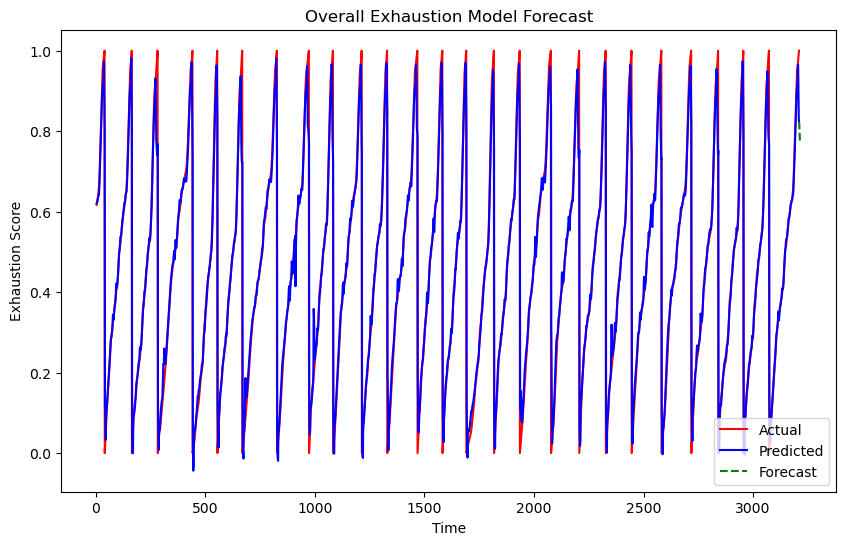

In [39]:
import numpy as np
import pandas as pd
import json
import sys
import logging
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


# ==================== UTILS ====================
def load_top_features(target, feature_dir="feature_lists"):
    """
    Loads the saved feature list for a specific target variable.
    
    Parameters:
      - target (str): Target variable name.
      - feature_dir (str): Directory containing feature lists.
    
    Returns:
      - List of feature names.
    """
    filename = Path(feature_dir) / f"{target}_model_feature_list.pkl"
    
    try:
        features = pd.read_pickle(filename)
        logging.info(f"Loaded {len(features)} features for {target}")
        
        # Verify features exist in data (assumes 'data' is already loaded in the global scope)
        missing = [f for f in features if f not in data.columns]
        if missing:
            logging.error(f"Missing features from {target} list: {missing}")
            sys.exit(1)
            
        return features
    
    except FileNotFoundError:
        logging.error(f"No feature list found for {target} at {filename}")
        sys.exit(1)
        
def temporal_train_test_split(data, test_size=0.2):
    """Time-based split maintaining temporal order"""
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    logging.info(f"Performed temporal train-test split with test size = {test_size}")
    logging.info(f"Training data shape: {train_data.shape}, Testing data shape: {test_data.shape}")
    return train_data, test_data

def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    logging.info("Features have been scaled using StandardScaler.")
    return X_train_scaled, X_test_scaled, scaler

def create_sequences(X, y, timesteps):
    """
    Creates sequences of data for LSTM input.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created LSTM sequences: {X_seq.shape}, {y_seq.shape}")
    return X_seq, y_seq
# ==================== TRAINING FUNCTIONS ====================

def train_exhaustion_model(train_data, test_data, features, timesteps, 
                           epochs=50, batch_size=32, early_stop_patience=5,
                           num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                           dense_units=1, dense_activation=None):
    """
    Trains the overall exhaustion model (regression) with a separate target scaler.

    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - features (list): List of feature column names for exhaustion.
      - timesteps (int): Number of past observations to include in each sequence.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - early_stop_patience (int): Patience for EarlyStopping callback.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str or None): Activation function for the Dense layer.
      
    Returns:
      - model_exhaustion: Trained Keras model.
      - scaler_exhaustion: Fitted scaler for the features.
      - target_scaler: Fitted scaler for the target values.
      - X_lstm_exhaustion_val, y_lstm_exhaustion_val: Validation sequences (targets are scaled).
    """
    # Extract features and target from training and testing data
    X_train = train_data[features].values
    y_train = train_data['by_trial_exhaustion_score'].values
    X_test = test_data[features].values
    y_test = test_data['by_trial_exhaustion_score'].values

    # Scale features using the existing helper function
    X_train_scaled, X_test_scaled, scaler_exhaustion = scale_features(X_train, X_test)
    
    # ---- New: Scale the target (exhaustion scores) separately ----
    from sklearn.preprocessing import StandardScaler
    target_scaler = StandardScaler()
    # Reshape y to 2D arrays for StandardScaler
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))
    # ------------------------------------------------------------------

    # Create sequences for LSTM input using the scaled features and scaled target values
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_scaled, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_scaled, timesteps)

    # ---- Model Construction using an explicit Input layer and architecture hyperparameters ----
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense

    model_exhaustion = Sequential()
    # Define the input shape
    model_exhaustion.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    # Add LSTM layers with dropout (all but last LSTM layer return sequences)
    for i in range(num_lstm_layers):
        return_seq = True if i < num_lstm_layers - 1 else False
        model_exhaustion.add(LSTM(lstm_units, return_sequences=return_seq))
        model_exhaustion.add(Dropout(dropout_rate))
    # Final Dense layer for output (for regression, no activation by default)
    model_exhaustion.add(Dense(dense_units, activation=dense_activation))
    # ----------------------------------------------------------------------------------------------

    model_exhaustion.compile(optimizer='adam', loss='mse')

    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=early_stop_patience)

    import logging
    logging.info("Training overall exhaustion model...")
    model_exhaustion.fit(
        X_lstm, y_lstm,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(X_lstm_val, y_lstm_val),
        callbacks=[early_stop]
    )

    # Return the model, the scaler for features, the separate target scaler, and validation sequences
    return model_exhaustion, scaler_exhaustion, target_scaler, X_lstm_val, y_lstm_val




def train_injury_model(train_data, test_data, features, timesteps,
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid'):
    """
    Trains the overall injury risk model.

    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - features (list): List of feature column names for injury risk.
      - timesteps (int): Number of past observations to include in each sequence.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str): Activation function for the Dense layer (default 'sigmoid' for classification).
      
    Returns:
      - model_injury: Trained Keras model.
      - scaler_injury: Fitted scaler for the features.
      - X_lstm_injury_val, y_lstm_injury_val: Validation sequences.
    """
    X_train = train_data[features].values
    y_train = train_data['injury_risk'].values
    X_test = test_data[features].values
    y_test = test_data['injury_risk'].values

    # Scale features
    X_train_scaled, X_test_scaled, scaler_injury = scale_features(X_train, X_test)
    # Create sequences for LSTM input
    X_lstm, y_lstm = create_sequences(X_train_scaled, y_train, timesteps)
    X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test, timesteps)

    # ---- Updated Model Construction using an explicit Input layer and architecture hyperparameters ----
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense

    model_injury = Sequential()
    model_injury.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
    for i in range(num_lstm_layers):
        return_seq = True if i < num_lstm_layers - 1 else False
        model_injury.add(LSTM(lstm_units, return_sequences=return_seq))
        model_injury.add(Dropout(dropout_rate))
    model_injury.add(Dense(dense_units, activation=dense_activation))
    # ----------------------------------------------------------------------------------------------

    model_injury.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    import logging
    logging.info("Training overall injury risk model...")
    model_injury.fit(
        X_lstm, y_lstm,
        epochs=epochs, 
        batch_size=batch_size,
        validation_data=(X_lstm_val, y_lstm_val)
    )

    return model_injury, scaler_injury, X_lstm_val, y_lstm_val
# ==================== JOINT-SPECIFIC TRAINING FUNCTION ====================



def train_joint_models(train_data, test_data, joints, timesteps, feature_dir,
                       epochs=50, batch_size=32,
                       num_lstm_layers=1, lstm_units=64, dropout_rate=0.2,
                       dense_units=1, dense_activation='sigmoid'):
    """
    Trains injury risk models for multiple joints.

    Parameters:
      - train_data (DataFrame): Training set.
      - test_data (DataFrame): Testing set.
      - joints (list): List of joint names.
      - timesteps (int): Number of past observations to include in each sequence.
      - feature_dir (str): Directory containing feature lists.
      - epochs (int): Number of training epochs.
      - batch_size (int): Batch size for training.
      - num_lstm_layers (int): Number of LSTM layers in the model.
      - lstm_units (int): Number of units in each LSTM layer.
      - dropout_rate (float): Dropout rate applied after each LSTM layer.
      - dense_units (int): Number of units in the final Dense layer.
      - dense_activation (str): Activation function for the Dense layer.
      
    Returns:
      - joint_models (dict): Dictionary with joint model info.
    """
    import logging
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dropout, Dense
    joint_models = {}

    for joint in joints:
        for side in ['L', 'R']:
            target_joint = f"{side}_{joint}_injury_risk"
            logging.info(f"Training model for {target_joint}...")

            joint_features = load_top_features(target_joint, feature_dir=feature_dir)

            X_train_joint = train_data[joint_features].values
            y_train_joint = train_data[target_joint].values
            X_test_joint = test_data[joint_features].values
            y_test_joint = test_data[target_joint].values

            # Scale features for the joint-specific model
            X_train_scaled, X_test_scaled, scaler_joint = scale_features(X_train_joint, X_test_joint)
            # Create sequences for LSTM input
            X_lstm, y_lstm = create_sequences(X_train_scaled, y_train_joint, timesteps)
            X_lstm_val, y_lstm_val = create_sequences(X_test_scaled, y_test_joint, timesteps)

            # ---- Updated Model Construction using an explicit Input layer and architecture hyperparameters ----
            model_joint = Sequential()
            model_joint.add(Input(shape=(X_lstm.shape[1], X_lstm.shape[2])))
            for i in range(num_lstm_layers):
                return_seq = True if i < num_lstm_layers - 1 else False
                model_joint.add(LSTM(lstm_units, return_sequences=return_seq))
                model_joint.add(Dropout(dropout_rate))
            model_joint.add(Dense(dense_units, activation=dense_activation))
            # ----------------------------------------------------------------------------------------------

            model_joint.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            model_joint.fit(
                X_lstm, y_lstm,
                epochs=epochs, 
                batch_size=batch_size,
                validation_data=(X_lstm_val, y_lstm_val)
            )

            joint_models[target_joint] = {
                'model': model_joint,
                'features': joint_features,
                'scaler': scaler_joint
            }

    import json
    with open("loaded_features.json", "w") as f:
        json.dump({target: info['features'] for target, info in joint_models.items()}, f, indent=4)
    logging.info("Saved loaded features list for each joint model to 'loaded_features.json'.")

    return joint_models




# ==================== FORECASTING FUNCTION ====================

def forecast_and_plot(model, test_data, forecast_features, scaler_exhaustion, target_scaler, timesteps, future_steps=0, title="Forecast"):
    """
    Generates predictions for the exhaustion target using multi-feature input.
    
    Instead of forecasting from a univariate target series, this version extracts the
    same features used during training (e.g. a 10-dimensional input), scales them using
    the features scaler (scaler_exhaustion), builds forecasting sequences, makes predictions,
    and finally inverse-transforms the predictions using the target scaler.
    
    Parameters:
      - model: Trained Keras model.
      - test_data (DataFrame): The test DataFrame containing all features.
      - forecast_features (list): List of feature names used for forecasting (e.g. features_exhaustion).
      - scaler_exhaustion: Fitted StandardScaler used to scale the features.
      - target_scaler: Fitted StandardScaler used to scale the target values.
      - timesteps (int): Number of past observations to include in each sequence.
      - future_steps (int): Number of future time steps to forecast.
                          (Note: Future forecasting is approximate since it assumes constant features.)
      - title (str): Plot title.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract multi-dimensional input from test data
    X_forecast = test_data[forecast_features].values  # shape (n, num_features)
    
    # Scale the features using the features scaler
    X_forecast_scaled = scaler_exhaustion.transform(X_forecast)
    
    # Create sequences for forecasting using a dummy y array (since only X is needed)
    X_seq, _ = create_sequences(X_forecast_scaled, np.zeros(len(X_forecast_scaled)), timesteps)
    
    # Make predictions on the scaled sequences
    predictions_scaled = model.predict(X_seq)
    # Inverse-transform predictions using the target scaler
    predictions = target_scaler.inverse_transform(predictions_scaled)
    
    forecast_predictions_inv = None
    if future_steps > 0:
        # For forecasting additional future steps, assume features remain constant.
        # WARNING: This is an approximation and may not be very accurate.
        current_sequence = X_seq[-1].copy()  # shape: (timesteps, num_features)
        forecast_predictions = []
        for _ in range(future_steps):
            next_pred = model.predict(current_sequence.reshape(1, timesteps, current_sequence.shape[1]))
            forecast_predictions.append(next_pred[0, 0])
            # Update sequence: remove first row and append the last row (assumed constant)
            new_row = current_sequence[-1, :].copy()
            current_sequence = np.vstack([current_sequence[1:], new_row])
        forecast_predictions = np.array(forecast_predictions).reshape(-1, 1)
        forecast_predictions_inv = target_scaler.inverse_transform(forecast_predictions)
    
    # Plot the actual exhaustion scores and predictions
    plt.figure(figsize=(10, 6))
    actual = test_data['by_trial_exhaustion_score'].values
    plt.plot(range(timesteps, len(actual)), actual[timesteps:], color='red', label='Actual')
    plt.plot(range(timesteps, len(actual)), predictions, color='blue', label='Predicted')
    if forecast_predictions_inv is not None:
        future_x = list(range(len(actual), len(actual) + future_steps))
        plt.plot(future_x, forecast_predictions_inv, color='green', linestyle='--', label='Forecast')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Exhaustion Score')
    plt.legend()
    plt.show()



# ==================== MAIN FUNCTION ====================

def main():
    import logging
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')

    # Data Loading and Preparation
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    feature_dir = "../../data/Deep_Learning_Final"

    data = load_data(csv_path, json_path)
    data = prepare_joint_features(data)
    data = feature_engineering(data)

    # ---- Added Step: Defragment the DataFrame to avoid Pandas fragmentation warnings ----
    data = data.copy()
    # -----------------------------------------------------------------------------------

    features_exhaustion = load_top_features('by_trial_exhaustion_score', feature_dir=feature_dir)
    features_injury = load_top_features('injury_risk', feature_dir=feature_dir)

    train_data, test_data = temporal_train_test_split(data, test_size=0.2)
    timesteps = 5

    # Hyperparameter adjustments for training (common training hyperparameters)
    hyperparams = {
        "epochs": 1,
        "batch_size": 32,
        "early_stop_patience": 5
    }

    # Architecture hyperparameters for the exhaustion (regression) model
    arch_exhaustion = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": None
    }

    # Architecture hyperparameters for the injury and joint (classification) models
    arch_injury = {
        "num_lstm_layers": 1,
        "lstm_units": 64,
        "dropout_rate": 0.2,
        "dense_units": 1,
        "dense_activation": "sigmoid"
    }

    # Train the overall exhaustion model with both training and architecture hyperparameters.
    # Note that the returned 'target_scaler' is used for scaling the target.
    model_exhaustion, scaler_exhaustion, target_scaler, X_val_exh, y_val_exh = train_exhaustion_model(
        train_data, test_data, features_exhaustion, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        early_stop_patience=hyperparams["early_stop_patience"],
        num_lstm_layers=arch_exhaustion["num_lstm_layers"],
        lstm_units=arch_exhaustion["lstm_units"],
        dropout_rate=arch_exhaustion["dropout_rate"],
        dense_units=arch_exhaustion["dense_units"],
        dense_activation=arch_exhaustion["dense_activation"]
    )

    # Train the overall injury risk model with hyperparameter adjustments
    model_injury, scaler_injury, X_val_injury, y_val_injury = train_injury_model(
        train_data, test_data, features_injury, timesteps,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )

    # Train joint-specific models with hyperparameter adjustments
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_models = train_joint_models(
        train_data, test_data, joints, timesteps, feature_dir,
        epochs=hyperparams["epochs"],
        batch_size=hyperparams["batch_size"],
        num_lstm_layers=arch_injury["num_lstm_layers"],
        lstm_units=arch_injury["lstm_units"],
        dropout_rate=arch_injury["dropout_rate"],
        dense_units=arch_injury["dense_units"],
        dense_activation=arch_injury["dense_activation"]
    )

    # Forecasting Example for the Exhaustion Model:
    # Note: Pass the 'target_scaler' (instead of the features scaler) to correctly invert scale the predictions.
    import numpy as np
    forecast_and_plot(
        model=model_exhaustion,
        test_data=test_data,
        forecast_features=features_exhaustion,  # use the same features as during training
        scaler_exhaustion=scaler_exhaustion,
        target_scaler=target_scaler,
        timesteps=timesteps,
        future_steps=10,
        title="Overall Exhaustion Model Forecast"
    )

if __name__ == "__main__":
    main()


    

In [ ]:
import numpy as np
import pandas as pd
import json
import sys
import logging
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

# ==================== UTILS (unchanged) ====================
def load_top_features(target, feature_dir="feature_lists"):
    """
    Loads the saved feature list for a specific target variable.
    
    Parameters:
      - target (str): Target variable name.
      - feature_dir (str): Directory containing feature lists.
    
    Returns:
      - List of feature names.
    """
    filename = Path(feature_dir) / f"{target}_model_feature_list.pkl"
    
    try:
        features = pd.read_pickle(filename)
        logging.info(f"Loaded {len(features)} features for {target}")
        
        # Verify features exist in data (assumes 'data' is already loaded in the global scope)
        missing = [f for f in features if f not in data.columns]
        if missing:
            logging.error(f"Missing features from {target} list: {missing}")
            sys.exit(1)
            
        return features
    
    except FileNotFoundError:
        logging.error(f"No feature list found for {target} at {filename}")
        sys.exit(1)

def temporal_train_test_split(data, test_size=0.2):
    """Time-based split maintaining temporal order"""
    split_idx = int(len(data) * (1 - test_size))
    train_data = data.iloc[:split_idx]
    test_data = data.iloc[split_idx:]
    logging.info(f"Performed temporal train-test split with test size = {test_size}")
    logging.info(f"Training data shape: {train_data.shape}, Testing data shape: {test_data.shape}")
    return train_data, test_data

def create_sequences(X, y, timesteps):
    """
    Creates sequences of data for LSTM input.
    """
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i])
        y_seq.append(y[i])
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    logging.info(f"Created LSTM sequences: {X_seq.shape}, {y_seq.shape}")
    return X_seq, y_seq



In [ ]:
# train.py
import logging
import sys
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import Parallel, delayed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# from utils import load_top_features, temporal_train_test_split, create_sequences


# datapreprocessor.py

import pandas as pd
import numpy as np
from typing import List, Dict, Optional, Tuple, Any
import logging
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC, SMOTEN, BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
import joblib  # For saving/loading transformers
from inspect import signature  # For parameter validation in SMOTE

class DataPreprocessor:
    def __init__(
        self,
        model_type: str,
        y_variable: List[str],
        ordinal_categoricals: List[str],
        nominal_categoricals: List[str],
        numericals: List[str],
        mode: str,  # 'train', 'predict', 'clustering'
        options: Optional[Dict] = None,
        debug: bool = False,
        normalize_debug: bool = False,
        normalize_graphs_output: bool = False,
        graphs_output_dir: str = './plots',
        transformers_dir: str = './transformers'
    ):
        """
        Initialize the DataPreprocessor with model type and feature lists.

        Args:
            model_type (str): Type of the machine learning model (e.g., 'Logistic Regression').
            y_variable (List[str]): List of target variable(s).
            ordinal_categoricals (List[str]): List of ordinal categorical features.
            nominal_categoricals (List[str]): List of nominal categorical features.
            numericals (List[str]): List of numerical features.
            mode (str): Operational mode ('train', 'predict', 'clustering').
            options (Optional[Dict]): User-defined options for preprocessing steps.
            debug (bool): General debug flag to control overall verbosity.
            normalize_debug (bool): Flag to display normalization plots.
            normalize_graphs_output (bool): Flag to save normalization plots.
            graphs_output_dir (str): Directory to save plots.
            transformers_dir (str): Directory to save/load transformers.
        """
        self.model_type = model_type
        self.y_variable = y_variable
        self.ordinal_categoricals = ordinal_categoricals
        self.nominal_categoricals = nominal_categoricals
        self.numericals = numericals
        self.mode = mode.lower()
        if self.mode not in ['train', 'predict', 'clustering']:
            raise ValueError("Mode must be one of 'train', 'predict', or 'clustering'.")
        self.options = options or {}
        self.debug = debug
        self.normalize_debug = normalize_debug
        self.normalize_graphs_output = normalize_graphs_output
        self.graphs_output_dir = graphs_output_dir
        self.transformers_dir = transformers_dir

        # Initialize categorical_indices to prevent AttributeError
        self.categorical_indices = []

        # Define model categories for accurate processing
        self.model_category = self.map_model_type_to_category()

        if self.model_category == 'unknown':
            self.logger = logging.getLogger(self.__class__.__name__)
            self.logger.error(f"Model category for '{self.model_type}' is unknown. Check your configuration.")
            raise ValueError(f"Model category for '{self.model_type}' is unknown. Check your configuration.")

        # Initialize y_variable based on mode and model category
        if self.mode in ['train', 'predict'] and self.model_category in ['classification', 'regression']:
            if not self.y_variable:
                if self.mode == 'train':
                    raise ValueError("Target variable 'y_variable' must be specified for supervised models in train mode.")
                # In predict mode, y_variable might not be present
        else:
            # For 'clustering' mode or unsupervised prediction
            self.y_variable = []

        # Initialize other variables
        self.scaler = None
        self.transformer = None
        self.ordinal_encoder = None
        self.nominal_encoder = None
        self.preprocessor = None
        self.smote = None
        self.feature_reasons = {col: '' for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals}
        self.preprocessing_steps = []
        self.normality_results = {}
        self.features_to_transform = []
        self.nominal_encoded_feature_names = []
        self.final_feature_order = []

        # Initialize placeholders for clustering-specific transformers
        self.cluster_transformers = {}
        self.cluster_model = None
        self.cluster_labels = None
        self.silhouette_score = None

        # Define default thresholds for SMOTE recommendations
        self.imbalance_threshold = self.options.get('smote_recommendation', {}).get('imbalance_threshold', 0.1)
        self.noise_threshold = self.options.get('smote_recommendation', {}).get('noise_threshold', 0.1)
        self.overlap_threshold = self.options.get('smote_recommendation', {}).get('overlap_threshold', 0.1)
        self.boundary_threshold = self.options.get('smote_recommendation', {}).get('boundary_threshold', 0.1)

        self.pipeline = None  # Initialize pipeline

        # Initialize logging
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.DEBUG if self.debug else logging.INFO)
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s [%(levelname)s] %(message)s')
        handler.setFormatter(formatter)
        if not self.logger.handlers:
            self.logger.addHandler(handler)
            
        # Initialize feature_reasons with 'all_numericals' for clustering
        self.feature_reasons = {col: '' for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals}
        if self.model_category == 'clustering':
            self.feature_reasons['all_numericals'] = ''

    def get_debug_flag(self, flag_name: str) -> bool:
        """
        Retrieve the value of a specific debug flag from the options.
        Args:
            flag_name (str): The name of the debug flag.
        Returns:
            bool: The value of the debug flag.
        """
        return self.options.get(flag_name, False)

    def _log(self, message: str, step: str, level: str = 'info'):
        """
        Internal method to log messages based on the step-specific debug flags.
        
        Args:
            message (str): The message to log.
            step (str): The preprocessing step name.
            level (str): The logging level ('info', 'debug', etc.).
        """
        debug_flag = self.get_debug_flag(f'debug_{step}')
        if debug_flag:
            if level == 'debug':
                self.logger.debug(message)
            elif level == 'info':
                self.logger.info(message)
            elif level == 'warning':
                self.logger.warning(message)
            elif level == 'error':
                self.logger.error(message)

    def map_model_type_to_category(self) -> str:
        """
        Map the model_type string to a predefined category based on keywords.

        Returns:
            str: The model category ('classification', 'regression', 'clustering', etc.).
        """
        classification_keywords = ['classifier', 'classification', 'logistic', 'svm', 'support vector machine', 'knn', 'neural network']
        regression_keywords = ['regressor', 'regression', 'linear', 'knn', 'neural network']  # Removed 'svm'
        clustering_keywords = ['k-means', 'clustering', 'dbscan', 'kmodes', 'kprototypes']

        model_type_lower = self.model_type.lower()

        for keyword in classification_keywords:
            if keyword in model_type_lower:
                return 'classification'

        for keyword in regression_keywords:
            if keyword in model_type_lower:
                return 'regression'

        for keyword in clustering_keywords:
            if keyword in model_type_lower:
                return 'clustering'

        return 'unknown'

    def filter_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        step_name = "filter_columns"
        self.logger.info(f"Step: {step_name}")

        # Combine all feature lists
        desired_features = self.numericals + self.ordinal_categoricals + self.nominal_categoricals

        # For 'train' and 'clustering' modes, handle y_variable appropriately
        if self.mode == 'train':
            # Ensure y_variable is present in the data but not included in features
            if not all(col in df.columns for col in self.y_variable):
                missing_y = [col for col in self.y_variable if col not in df.columns]
                self.logger.error(f"Target variable(s) {missing_y} not found in the input data.")
                raise ValueError(f"Target variable(s) {missing_y} not found in the input data.")
            # Exclude y_variable from features
            desired_features = [col for col in desired_features if col not in self.y_variable]
            # Retain y_variable in the filtered DataFrame
            filtered_df = df[desired_features + self.y_variable].copy()
        else:
            # For 'predict' and 'clustering' modes, exclude y_variable
            filtered_df = df[desired_features].copy()

        # Identify missing features in the input DataFrame
        missing_features = [col for col in desired_features if col not in df.columns]
        if missing_features:
            self.logger.error(f"The following required features are missing in the input data: {missing_features}")
            raise ValueError(f"The following required features are missing in the input data: {missing_features}")

        # Log the filtering action
        self.logger.info(f"✅ Filtered DataFrame to include only specified features. Shape: {filtered_df.shape}")
        self.logger.debug(f"Selected Features: {desired_features}")
        if self.mode == 'train':
            self.logger.debug(f"Retained Target Variable(s): {self.y_variable}")

        return filtered_df

    def split_dataset(
        self,
        X: pd.DataFrame,
        y: Optional[pd.Series] = None
    ) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.Series], Optional[pd.Series]]:
        """
        Split the dataset into training and testing sets while retaining original indices.

        Args:
            X (pd.DataFrame): Features.
            y (Optional[pd.Series]): Target variable.

        Returns:
            Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.Series], Optional[pd.Series]]: X_train, X_test, y_train, y_test
        """
        step_name = "split_dataset"
        self.logger.info("Step: Split Dataset into Train and Test")

        # Debugging Statements
        self._log(f"Before Split - X shape: {X.shape}", step_name, 'debug')
        if y is not None:
            self._log(f"Before Split - y shape: {y.shape}", step_name, 'debug')
        else:
            self._log("Before Split - y is None", step_name, 'debug')

        # Determine splitting based on mode
        if self.mode == 'train' and self.model_category in ['classification', 'regression']:
            if self.model_category == 'classification':
                stratify = y if self.options.get('split_dataset', {}).get('stratify_for_classification', False) else None
                test_size = self.options.get('split_dataset', {}).get('test_size', 0.2)
                random_state = self.options.get('split_dataset', {}).get('random_state', 42)
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, 
                    test_size=test_size,
                    stratify=stratify, 
                    random_state=random_state
                )
                self._log("Performed stratified split for classification.", step_name, 'debug')
            elif self.model_category == 'regression':
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, 
                    test_size=self.options.get('split_dataset', {}).get('test_size', 0.2),
                    random_state=self.options.get('split_dataset', {}).get('random_state', 42)
                )
                self._log("Performed random split for regression.", step_name, 'debug')
        else:
            # For 'predict' and 'clustering' modes or other categories
            X_train = X.copy()
            X_test = None
            y_train = y.copy() if y is not None else None
            y_test = None
            self.logger.info(f"No splitting performed for mode '{self.mode}' or model category '{self.model_category}'.")

        self.preprocessing_steps.append("Split Dataset into Train and Test")

        # Keep Indices Aligned Through Each Step
        if X_test is not None and y_test is not None:
            # Sort both X_test and y_test by index
            X_test = X_test.sort_index()
            y_test = y_test.sort_index()
            self.logger.debug("Sorted X_test and y_test by index for alignment.")

        # Debugging: Log post-split shapes and index alignment
        self._log(f"After Split - X_train shape: {X_train.shape}, X_test shape: {X_test.shape if X_test is not None else 'N/A'}", step_name, 'debug')
        if self.model_category == 'classification' and y_train is not None and y_test is not None:
            self.logger.debug(f"Class distribution in y_train:\n{y_train.value_counts(normalize=True)}")
            self.logger.debug(f"Class distribution in y_test:\n{y_test.value_counts(normalize=True)}")
        elif self.model_category == 'regression' and y_train is not None and y_test is not None:
            self.logger.debug(f"y_train statistics:\n{y_train.describe()}")
            self.logger.debug(f"y_test statistics:\n{y_test.describe()}")

        # Check index alignment
        if y_train is not None and X_train.index.equals(y_train.index):
            self.logger.debug("X_train and y_train indices are aligned.")
        else:
            self.logger.warning("X_train and y_train indices are misaligned.")

        if X_test is not None and y_test is not None and X_test.index.equals(y_test.index):
            self.logger.debug("X_test and y_test indices are aligned.")
        elif X_test is not None and y_test is not None:
            self.logger.warning("X_test and y_test indices are misaligned.")

        return X_train, X_test, y_train, y_test

    def handle_missing_values(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Handle missing values for numerical and categorical features based on user options.
        """
        step_name = "handle_missing_values"
        self.logger.info("Step: Handle Missing Values")

        # Fetch user-defined imputation options or set defaults
        impute_options = self.options.get('handle_missing_values', {})
        numerical_strategy = impute_options.get('numerical_strategy', {})
        categorical_strategy = impute_options.get('categorical_strategy', {})

        # Numerical Imputation
        numerical_imputer = None
        new_columns = []
        if self.numericals:
            if self.model_category in ['regression', 'classification', 'clustering']:
                default_num_strategy = 'median'  # Changed to median as per preprocessor_config.yaml
            else:
                default_num_strategy = 'median'
            num_strategy = numerical_strategy.get('strategy', default_num_strategy)
            num_imputer_type = numerical_strategy.get('imputer', 'SimpleImputer')  # Can be 'SimpleImputer', 'KNNImputer', etc.

            self._log(f"Numerical Imputation Strategy: {num_strategy.capitalize()}, Imputer Type: {num_imputer_type}", step_name, 'debug')

            # Initialize numerical imputer based on user option
            if num_imputer_type == 'SimpleImputer':
                numerical_imputer = SimpleImputer(strategy=num_strategy)
            elif num_imputer_type == 'KNNImputer':
                knn_neighbors = numerical_strategy.get('knn_neighbors', 5)
                numerical_imputer = KNNImputer(n_neighbors=knn_neighbors)
            else:
                self.logger.error(f"Numerical imputer type '{num_imputer_type}' is not supported.")
                raise ValueError(f"Numerical imputer type '{num_imputer_type}' is not supported.")

            # Fit and transform ONLY on X_train
            X_train[self.numericals] = numerical_imputer.fit_transform(X_train[self.numericals])
            self.numerical_imputer = numerical_imputer  # Assign to self for saving
            self.feature_reasons.update({col: self.feature_reasons.get(col, '') + f'Numerical: {num_strategy.capitalize()} Imputation | ' for col in self.numericals})
            new_columns.extend(self.numericals)

            if X_test is not None:
                # Transform ONLY on X_test without fitting
                X_test[self.numericals] = numerical_imputer.transform(X_test[self.numericals])

        # Categorical Imputation
        categorical_imputer = None
        all_categoricals = self.ordinal_categoricals + self.nominal_categoricals
        if all_categoricals:
            default_cat_strategy = 'most_frequent'
            cat_strategy = categorical_strategy.get('strategy', default_cat_strategy)
            cat_imputer_type = categorical_strategy.get('imputer', 'SimpleImputer')

            self._log(f"Categorical Imputation Strategy: {cat_strategy.capitalize()}, Imputer Type: {cat_imputer_type}", step_name, 'debug')

            # Initialize categorical imputer based on user option
            if cat_imputer_type == 'SimpleImputer':
                categorical_imputer = SimpleImputer(strategy=cat_strategy)
            elif cat_imputer_type == 'ConstantImputer':
                fill_value = categorical_strategy.get('fill_value', 'Missing')
                categorical_imputer = SimpleImputer(strategy='constant', fill_value=fill_value)
            else:
                self.logger.error(f"Categorical imputer type '{cat_imputer_type}' is not supported.")
                raise ValueError(f"Categorical imputer type '{cat_imputer_type}' is not supported.")

            # Fit and transform ONLY on X_train
            X_train[all_categoricals] = categorical_imputer.fit_transform(X_train[all_categoricals])
            self.categorical_imputer = categorical_imputer  # Assign to self for saving
            self.feature_reasons.update({
                col: self.feature_reasons.get(col, '') + (f'Categorical: Constant Imputation (Value={categorical_strategy.get("fill_value", "Missing")}) | ' if cat_imputer_type == 'ConstantImputer' else f'Categorical: {cat_strategy.capitalize()} Imputation | ')
                for col in all_categoricals
            })
            new_columns.extend(all_categoricals)

            if X_test is not None:
                # Transform ONLY on X_test without fitting
                X_test[all_categoricals] = categorical_imputer.transform(X_test[all_categoricals])

        self.preprocessing_steps.append("Handle Missing Values")

        # Debugging: Log post-imputation shapes and missing values
        self._log(f"Completed: Handle Missing Values. Dataset shape after imputation: {X_train.shape}", step_name, 'debug')
        self._log(f"Missing values after imputation in X_train:\n{X_train.isnull().sum()}", step_name, 'debug')
        self._log(f"New columns handled: {new_columns}", step_name, 'debug')

        return X_train, X_test

    def handle_outliers(self, X_train: pd.DataFrame, y_train: Optional[pd.Series] = None) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        """
        Handle outliers based on the model's sensitivity and user options.

        Args:
            X_train (pd.DataFrame): Training features.
            y_train (pd.Series, optional): Training target.

        Returns:
            tuple: X_train without outliers and corresponding y_train.
        """
        step_name = "handle_outliers"
        self.logger.info("Step: Handle Outliers")
        self._log("Starting outlier handling.", step_name, 'debug')

        debug_flag = self.get_debug_flag('debug_handle_outliers')
        initial_shape = X_train.shape[0]

        # Fetch user-defined outlier handling options or set defaults
        outlier_options = self.options.get('handle_outliers', {})
        zscore_threshold = outlier_options.get('zscore_threshold', 3)
        iqr_multiplier = outlier_options.get('iqr_multiplier', 1.5)
        isolation_contamination = outlier_options.get('isolation_contamination', 0.05)

        if self.model_category in ['regression', 'classification']:
            self.logger.info(f"Applying univariate outlier detection for {self.model_category}.")
            for col in self.numericals:
                # Z-Score Filtering
                apply_zscore = outlier_options.get('apply_zscore', True)
                if apply_zscore:
                    z_scores = np.abs((X_train[col] - X_train[col].mean()) / X_train[col].std())
                    mask_z = z_scores < zscore_threshold
                    removed_z = (~mask_z).sum()
                    X_train = X_train[mask_z]
                    if y_train is not None:
                        y_train = y_train.loc[X_train.index]
                    self.feature_reasons[col] += f'Outliers handled with Z-Score Filtering (threshold={zscore_threshold}) | '
                    self._log(f"Removed {removed_z} outliers from '{col}' using Z-Score Filtering.", step_name, 'debug')

                # IQR Filtering
                apply_iqr = outlier_options.get('apply_iqr', True)
                if apply_iqr:
                    Q1 = X_train[col].quantile(0.25)
                    Q3 = X_train[col].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - iqr_multiplier * IQR
                    upper_bound = Q3 + iqr_multiplier * IQR
                    mask_iqr = (X_train[col] >= lower_bound) & (X_train[col] <= upper_bound)
                    removed_iqr = (~mask_iqr).sum()
                    X_train = X_train[mask_iqr]
                    if y_train is not None:
                        y_train = y_train.loc[X_train.index]
                    self.feature_reasons[col] += f'Outliers handled with IQR Filtering (multiplier={iqr_multiplier}) | '
                    self._log(f"Removed {removed_iqr} outliers from '{col}' using IQR Filtering.", step_name, 'debug')

        elif self.model_category == 'clustering':
            self.logger.info("Applying multivariate IsolationForest for clustering.")
            # Apply IsolationForest on all numerical features simultaneously
            contamination = isolation_contamination
            iso_forest = IsolationForest(contamination=contamination, random_state=42)
            preds = iso_forest.fit_predict(X_train[self.numericals])
            mask_iso = preds != -1
            removed_iso = (preds == -1).sum()
            X_train = X_train[mask_iso]
            if y_train is not None:
                y_train = y_train.loc[X_train.index]  # Should typically be None in clustering
            self.feature_reasons['all_numericals'] += f'Outliers handled with Multivariate IsolationForest (contamination={contamination}) | '
            self._log(f"Removed {removed_iso} outliers using Multivariate IsolationForest.", step_name, 'debug')

        else:
            self.logger.warning(f"Model category '{self.model_category}' not recognized for outlier handling.")

        self.preprocessing_steps.append("Handle Outliers")

        # Completion Logging
        self._log(f"Completed: Handle Outliers. Initial samples: {initial_shape}, Final samples: {X_train.shape[0]}", step_name, 'debug')
        self._log(f"Missing values after outlier handling in X_train:\n{X_train.isnull().sum()}", step_name, 'debug')

        return X_train, y_train

    def test_normality(self, X_train: pd.DataFrame) -> Dict[str, Dict]:
        """
        Test normality for numerical features based on normality tests and user options.

        Args:
            X_train (pd.DataFrame): Training features.

        Returns:
            Dict[str, Dict]: Dictionary with normality test results for each numerical feature.
        """
        step_name = "Test for Normality"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_test_normality')
        normality_results = {}

        # Fetch user-defined normality test options or set defaults
        normality_options = self.options.get('test_normality', {})
        p_value_threshold = normality_options.get('p_value_threshold', 0.05)
        skewness_threshold = normality_options.get('skewness_threshold', 1.0)
        additional_tests = normality_options.get('additional_tests', [])  # e.g., ['anderson-darling']

        for col in self.numericals:
            data = X_train[col].dropna()
            skewness = data.skew()
            kurtosis = data.kurtosis()

            # Determine which normality test to use based on sample size and user options
            test_used = 'Shapiro-Wilk'
            p_value = 0.0

            if len(data) <= 5000:
                from scipy.stats import shapiro
                stat, p_val = shapiro(data)
                test_used = 'Shapiro-Wilk'
                p_value = p_val
            else:
                from scipy.stats import anderson
                result = anderson(data)
                test_used = 'Anderson-Darling'
                # Determine p-value based on critical values
                p_value = 0.0  # Default to 0
                for cv, sig in zip(result.critical_values, result.significance_level):
                    if result.statistic < cv:
                        p_value = sig / 100
                        break

            # Apply user-defined or default criteria
            if self.model_category in ['regression', 'classification', 'clustering']:
                # Linear, Logistic Regression, and Clustering: Use p-value and skewness
                needs_transform = (p_value < p_value_threshold) or (abs(skewness) > skewness_threshold)
            else:
                # Other models: Use skewness, and optionally p-values based on options
                use_p_value = normality_options.get('use_p_value_other_models', False)
                if use_p_value:
                    needs_transform = (p_value < p_value_threshold) or (abs(skewness) > skewness_threshold)
                else:
                    needs_transform = abs(skewness) > skewness_threshold

            normality_results[col] = {
                'skewness': skewness,
                'kurtosis': kurtosis,
                'p_value': p_value,
                'test_used': test_used,
                'needs_transform': needs_transform
            }

            # Conditional Detailed Logging
            if debug_flag:
                self._log(f"Feature '{col}': p-value={p_value:.4f}, skewness={skewness:.4f}, needs_transform={needs_transform}", step_name, 'debug')

        self.normality_results = normality_results
        self.preprocessing_steps.append(step_name)

        # Completion Logging
        if debug_flag:
            self._log(f"Completed: {step_name}. Normality results computed.", step_name, 'debug')
        else:
            self.logger.info(f"Step '{step_name}' completed: Normality results computed.")

        return normality_results

    def encode_categorical_variables(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Encode categorical variables using user-specified encoding strategies.
        """
        step_name = "encode_categorical_variables"
        self.logger.info("Step: Encode Categorical Variables")
        self._log("Starting categorical variable encoding.", step_name, 'debug')

        # Fetch user-defined encoding options or set defaults
        encoding_options = self.options.get('encode_categoricals', {})
        ordinal_encoding = encoding_options.get('ordinal_encoding', 'OrdinalEncoder')  # Options: 'OrdinalEncoder', 'None'
        nominal_encoding = encoding_options.get('nominal_encoding', 'OneHotEncoder')  # Changed from 'OneHotEncoder' to 'OrdinalEncoder'
        handle_unknown = encoding_options.get('handle_unknown', 'use_encoded_value')  # Adjusted for OrdinalEncoder

        # Determine if SMOTENC is being used
        smote_variant = self.options.get('implement_smote', {}).get('variant', None)
        if smote_variant == 'SMOTENC':
            nominal_encoding = 'OrdinalEncoder'  # Ensure compatibility

        transformers = []
        new_columns = []
        if self.ordinal_categoricals and ordinal_encoding != 'None':
            if ordinal_encoding == 'OrdinalEncoder':
                transformers.append(
                    ('ordinal', OrdinalEncoder(), self.ordinal_categoricals)
                )
                self._log(f"Added OrdinalEncoder for features: {self.ordinal_categoricals}", step_name, 'debug')
            else:
                self.logger.error(f"Ordinal encoding method '{ordinal_encoding}' is not supported.")
                raise ValueError(f"Ordinal encoding method '{ordinal_encoding}' is not supported.")
        if self.nominal_categoricals and nominal_encoding != 'None':
            if nominal_encoding == 'OrdinalEncoder':
                transformers.append(
                    ('nominal', OrdinalEncoder(handle_unknown=handle_unknown), self.nominal_categoricals)
                )
                self._log(f"Added OrdinalEncoder for features: {self.nominal_categoricals}", step_name, 'debug')
            elif nominal_encoding == 'FrequencyEncoder':
                # Custom Frequency Encoding
                for col in self.nominal_categoricals:
                    freq = X_train[col].value_counts(normalize=True)
                    X_train[col] = X_train[col].map(freq)
                    if X_test is not None:
                        X_test[col] = X_test[col].map(freq).fillna(0)
                    self.feature_reasons[col] += 'Encoded with Frequency Encoding | '
                    self._log(f"Applied Frequency Encoding to '{col}'.", step_name, 'debug')
            else:
                self.logger.error(f"Nominal encoding method '{nominal_encoding}' is not supported.")
                raise ValueError(f"Nominal encoding method '{nominal_encoding}' is not supported.")

        if not transformers and 'FrequencyEncoder' not in nominal_encoding:
            self.logger.info("No categorical variables to encode.")
            self.preprocessing_steps.append("Encode Categorical Variables")
            self._log(f"Completed: Encode Categorical Variables. No encoding was applied.", step_name, 'debug')
            return X_train, X_test

        if transformers:
            self.preprocessor = ColumnTransformer(
                transformers=transformers,
                remainder='passthrough',
                verbose_feature_names_out=False  # Disable prefixing
            )

            # Fit and transform training data
            X_train_encoded = self.preprocessor.fit_transform(X_train)
            self._log("Fitted and transformed X_train with ColumnTransformer.", step_name, 'debug')

            # Transform testing data
            if X_test is not None:
                X_test_encoded = self.preprocessor.transform(X_test)
                self._log("Transformed X_test with fitted ColumnTransformer.", step_name, 'debug')
            else:
                X_test_encoded = None

            # Retrieve feature names after encoding
            encoded_feature_names = []
            if self.ordinal_categoricals and ordinal_encoding == 'OrdinalEncoder':
                encoded_feature_names += self.ordinal_categoricals
            if self.nominal_categoricals and nominal_encoding == 'OrdinalEncoder':
                encoded_feature_names += self.nominal_categoricals
            elif self.nominal_categoricals and nominal_encoding == 'FrequencyEncoder':
                encoded_feature_names += self.nominal_categoricals
            passthrough_features = [col for col in X_train.columns if col not in self.ordinal_categoricals + self.nominal_categoricals]
            encoded_feature_names += passthrough_features
            new_columns.extend(encoded_feature_names)

            # Convert numpy arrays back to DataFrames
            X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
            if X_test_encoded is not None:
                X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)
            else:
                X_test_encoded_df = None

            # Store encoders for inverse transformation
            self.ordinal_encoder = self.preprocessor.named_transformers_.get('ordinal', None)
            self.nominal_encoder = self.preprocessor.named_transformers_.get('nominal', None)

            self.preprocessing_steps.append("Encode Categorical Variables")
            self._log(f"Completed: Encode Categorical Variables. X_train_encoded shape: {X_train_encoded_df.shape}", step_name, 'debug')
            self._log(f"Columns after encoding: {encoded_feature_names}", step_name, 'debug')
            self._log(f"Sample of encoded X_train:\n{X_train_encoded_df.head()}", step_name, 'debug')
            self._log(f"New columns added: {new_columns}", step_name, 'debug')

            return X_train_encoded_df, X_test_encoded_df

    def generate_recommendations(self) -> pd.DataFrame:
        """
        Generate a table of preprocessing recommendations based on the model type, data, and user options.

        Returns:
            pd.DataFrame: DataFrame containing recommendations for each feature.
        """
        step_name = "Generate Preprocessor Recommendations"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_generate_recommendations')

        # Generate recommendations based on feature reasons
        recommendations = {}
        for col in self.ordinal_categoricals + self.nominal_categoricals + self.numericals:
            reasons = self.feature_reasons.get(col, '').strip(' | ')
            recommendations[col] = reasons

        recommendations_table = pd.DataFrame.from_dict(
            recommendations, 
            orient='index', 
            columns=['Preprocessing Reason']
        )
        if debug_flag:
            self.logger.debug(f"Preprocessing Recommendations:\n{recommendations_table}")
        else:
            self.logger.info("Preprocessing Recommendations generated.")

        self.preprocessing_steps.append(step_name)

        # Completion Logging
        if debug_flag:
            self._log(f"Completed: {step_name}. Recommendations generated.", step_name, 'debug')
        else:
            self.logger.info(f"Step '{step_name}' completed: Recommendations generated.")

        return recommendations_table

    def save_transformers(self):
        step_name = "Save Transformers"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_save_transformers')
        
        # Ensure the transformers directory exists
        os.makedirs(self.transformers_dir, exist_ok=True)
        transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')  # Consistent file path
        
        transformers = {
            'numerical_imputer': getattr(self, 'numerical_imputer', None),
            'categorical_imputer': getattr(self, 'categorical_imputer', None),
            'preprocessor': self.pipeline,   # Includes all preprocessing steps
            'smote': self.smote,
            'final_feature_order': self.final_feature_order,
            'categorical_indices': self.categorical_indices
        }
        try:
            joblib.dump(transformers, transformers_path)
            if debug_flag:
                self._log(f"Transformers saved at '{transformers_path}'.", step_name, 'debug')
            else:
                self.logger.info(f"Transformers saved at '{transformers_path}'.")
        except Exception as e:
            self.logger.error(f"❌ Failed to save transformers: {e}")
            raise

        self.preprocessing_steps.append(step_name)

    def load_transformers(self) -> dict:
        step_name = "Load Transformers"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_load_transformers')  # Assuming a step-specific debug flag
        transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')  # Correct path

        # Debug log
        self.logger.debug(f"Loading transformers from: {transformers_path}")

        if not os.path.exists(transformers_path):
            self.logger.error(f"❌ Transformers file not found at '{transformers_path}'. Cannot proceed with prediction.")
            raise FileNotFoundError(f"Transformers file not found at '{transformers_path}'.")

        try:
            transformers = joblib.load(transformers_path)

            # Extract transformers
            numerical_imputer = transformers.get('numerical_imputer')
            categorical_imputer = transformers.get('categorical_imputer')
            preprocessor = transformers.get('preprocessor')
            smote = transformers.get('smote', None)
            final_feature_order = transformers.get('final_feature_order', [])
            categorical_indices = transformers.get('categorical_indices', [])
            self.categorical_indices = categorical_indices  # Set the attribute

            # **Post-Loading Debugging:**
            if preprocessor is not None:
                try:
                    # Do not attempt to transform dummy data here
                    self.logger.debug(f"Pipeline loaded. Ready to transform new data.")
                except AttributeError as e:
                    self.logger.error(f"Pipeline's get_feature_names_out is not available: {e}")
                    expected_features = []
            else:
                self.logger.error("❌ Preprocessor is not loaded.")
                raise AttributeError("Preprocessor is not loaded.")

        except Exception as e:
            self.logger.error(f"❌ Failed to load transformers: {e}")
            raise

        self.preprocessing_steps.append(step_name)

        # Additional checks
        if preprocessor is None:
            self.logger.error("❌ Preprocessor is not loaded.")

        if debug_flag:
            self._log(f"Transformers loaded successfully from '{transformers_path}'.", step_name, 'debug')
        else:
            self.logger.info(f"Transformers loaded successfully from '{transformers_path}'.")

        # Set the pipeline
        self.pipeline = preprocessor

        # Return the transformers as a dictionary
        return {
            'numerical_imputer': numerical_imputer,
            'categorical_imputer': categorical_imputer,
            'preprocessor': preprocessor,
            'smote': smote,
            'final_feature_order': final_feature_order,
            'categorical_indices': categorical_indices
        }

    def apply_scaling(self, X_train: pd.DataFrame, X_test: Optional[pd.DataFrame] = None) -> Tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Apply scaling based on the model type and user options.

        Args:
            X_train (pd.DataFrame): Training features.
            X_test (Optional[pd.DataFrame]): Testing features.

        Returns:
            Tuple[pd.DataFrame, Optional[pd.DataFrame]]: Scaled X_train and X_test.
        """
        step_name = "Apply Scaling (If Needed by Model)"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_apply_scaling')

        # Fetch user-defined scaling options or set defaults
        scaling_options = self.options.get('apply_scaling', {})
        scaling_method = scaling_options.get('method', None)  # 'StandardScaler', 'MinMaxScaler', 'RobustScaler', 'None'
        features_to_scale = scaling_options.get('features', self.numericals)

        scaler = None
        scaling_type = 'None'

        if scaling_method is None:
            # Default scaling based on model category
            if self.model_category in ['regression', 'classification', 'clustering']:
                # For clustering, MinMaxScaler is generally preferred
                if self.model_category == 'clustering':
                    scaler = MinMaxScaler()
                    scaling_type = 'MinMaxScaler'
                else:
                    scaler = StandardScaler()
                    scaling_type = 'StandardScaler'
            else:
                scaler = None
                scaling_type = 'None'
        else:
            # Normalize the scaling_method string to handle case-insensitivity
            scaling_method_normalized = scaling_method.lower()
            if scaling_method_normalized == 'standardscaler':
                scaler = StandardScaler()
                scaling_type = 'StandardScaler'
            elif scaling_method_normalized == 'minmaxscaler':
                scaler = MinMaxScaler()
                scaling_type = 'MinMaxScaler'
            elif scaling_method_normalized == 'robustscaler':
                scaler = RobustScaler()
                scaling_type = 'RobustScaler'
            elif scaling_method_normalized == 'none':
                scaler = None
                scaling_type = 'None'
            else:
                self.logger.error(f"Scaling method '{scaling_method}' is not supported.")
                raise ValueError(f"Scaling method '{scaling_method}' is not supported.")

        # Apply scaling if scaler is defined
        if scaler is not None and features_to_scale:
            self.scaler = scaler
            if debug_flag:
                self._log(f"Features to scale: {features_to_scale}", step_name, 'debug')

            # Check if features exist in the dataset
            missing_features = [feat for feat in features_to_scale if feat not in X_train.columns]
            if missing_features:
                self.logger.error(f"The following features specified for scaling are missing in the dataset: {missing_features}")
                raise KeyError(f"The following features specified for scaling are missing in the dataset: {missing_features}")

            X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
            if X_test is not None:
                X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

            for col in features_to_scale:
                self.feature_reasons[col] += f'Scaling Applied: {scaling_type} | '

            self.preprocessing_steps.append(step_name)
            if debug_flag:
                self._log(f"Applied {scaling_type} to features: {features_to_scale}", step_name, 'debug')
                if hasattr(scaler, 'mean_'):
                    self._log(f"Scaler Parameters: mean={scaler.mean_}", step_name, 'debug')
                if hasattr(scaler, 'scale_'):
                    self._log(f"Scaler Parameters: scale={scaler.scale_}", step_name, 'debug')
                self._log(f"Sample of scaled X_train:\n{X_train[features_to_scale].head()}", step_name, 'debug')
                if X_test is not None:
                    self._log(f"Sample of scaled X_test:\n{X_test[features_to_scale].head()}", step_name, 'debug')
            else:
                self.logger.info(f"Step '{step_name}' completed: Applied {scaling_type} to features: {features_to_scale}")
        else:
            self.logger.info("No scaling applied based on user options or no features specified.")
            self.preprocessing_steps.append(step_name)
            if debug_flag:
                self._log(f"Completed: {step_name}. No scaling was applied.", step_name, 'debug')
            else:
                self.logger.info(f"Step '{step_name}' completed: No scaling was applied.")

        return X_train, X_test

    def determine_n_neighbors(self, minority_count: int, default_neighbors: int = 5) -> int:
        """
        Determine the appropriate number of neighbors for SMOTE based on minority class size.

        Args:
            minority_count (int): Number of samples in the minority class.
            default_neighbors (int): Default number of neighbors to use if possible.

        Returns:
            int: Determined number of neighbors for SMOTE.
        """
        if minority_count <= 1:
            raise ValueError("SMOTE cannot be applied when the minority class has less than 2 samples.")
        
        # Ensure n_neighbors does not exceed minority_count - 1
        n_neighbors = min(default_neighbors, minority_count - 1)
        return n_neighbors

    def implement_smote(self, X_train: pd.DataFrame, y_train: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        """
        Implement SMOTE or its variants based on class imbalance with automated n_neighbors selection.

        Args:
            X_train (pd.DataFrame): Training features (transformed).
            y_train (pd.Series): Training target.

        Returns:
            Tuple[pd.DataFrame, pd.Series]: Resampled X_train and y_train.
        """
        step_name = "Implement SMOTE (Train Only)"
        self.logger.info(f"Step: {step_name}")

        # Check if classification
        if self.model_category != 'classification':
            self.logger.info("SMOTE not applicable: Not a classification model.")
            self.preprocessing_steps.append("SMOTE Skipped")
            return X_train, y_train

        # Calculate class distribution
        class_counts = y_train.value_counts()
        if len(class_counts) < 2:
            self.logger.warning("SMOTE not applicable: Only one class present.")
            self.preprocessing_steps.append("SMOTE Skipped")
            return X_train, y_train

        majority_class = class_counts.idxmax()
        minority_class = class_counts.idxmin()
        majority_count = class_counts.max()
        minority_count = class_counts.min()
        imbalance_ratio = minority_count / majority_count
        self.logger.info(f"Class Distribution before SMOTE: {class_counts.to_dict()}")
        self.logger.info(f"Imbalance Ratio (Minority/Majority): {imbalance_ratio:.4f}")

        # Determine SMOTE variant based on dataset composition
        has_numericals = len(self.numericals) > 0
        has_categoricals = len(self.ordinal_categoricals) + len(self.nominal_categoricals) > 0

        # Automatically select SMOTE variant
        if has_numericals and has_categoricals:
            smote_variant = 'SMOTENC'
            self.logger.info("Dataset contains both numerical and categorical features. Using SMOTENC.")
        elif has_numericals and not has_categoricals:
            smote_variant = 'SMOTE'
            self.logger.info("Dataset contains only numerical features. Using SMOTE.")
        elif has_categoricals and not has_numericals:
            smote_variant = 'SMOTEN'
            self.logger.info("Dataset contains only categorical features. Using SMOTEN.")
        else:
            smote_variant = 'SMOTE'  # Fallback
            self.logger.info("Feature composition unclear. Using SMOTE as default.")

        # Initialize SMOTE based on the variant
        try:
            if smote_variant == 'SMOTENC':
                if not self.categorical_indices:
                    categorical_features = []
                    offset = 0
                    # Use running offset to calculate correct indices in the concatenated output
                    for name, transformer, features in self.pipeline.transformers_:
                        # Determine number of output columns from this transformer
                        if hasattr(transformer, 'get_feature_names_out'):
                            out_features = transformer.get_feature_names_out(features)
                            n_cols = len(out_features)
                        else:
                            n_cols = len(features)  # fallback
                        if name in ['ord', 'nominal', 'nominal_ord']:
                            categorical_features.extend(list(range(offset, offset + n_cols)))
                        offset += n_cols
                    self.categorical_indices = categorical_features
                    self.logger.debug(f"Categorical feature indices for SMOTENC: {self.categorical_indices}")
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTENC(categorical_features=self.categorical_indices, random_state=42, k_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTENC with categorical features indices: {self.categorical_indices} and n_neighbors={n_neighbors}")
            elif smote_variant == 'SMOTEN':
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTEN(random_state=42, n_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTEN with n_neighbors={n_neighbors}")
            else:
                n_neighbors = self.determine_n_neighbors(minority_count, default_neighbors=5)
                smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
                self.logger.debug(f"Initialized SMOTE with n_neighbors={n_neighbors}")
        except ValueError as ve:
            self.logger.error(f"❌ SMOTE initialization failed: {ve}")
            raise
        except Exception as e:
            self.logger.error(f"❌ Unexpected error during SMOTE initialization: {e}")
            raise

        # Apply SMOTE
        try:
            X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
            self.logger.info(f"Applied {smote_variant}. Resampled dataset shape: {X_resampled.shape}")
            self.preprocessing_steps.append("Implement SMOTE")
            self.smote = smote  # Save SMOTE instance for later use
            self.logger.debug(f"Selected n_neighbors for SMOTE: {n_neighbors}")
            return X_resampled, y_resampled
        except Exception as e:
            self.logger.error(f"❌ SMOTE application failed: {e}")
            raise


    def inverse_transform_data(self, X_transformed: np.ndarray, original_data: Optional[pd.DataFrame] = None) -> pd.DataFrame:
        """
        Perform inverse transformation on the transformed data to reconstruct original feature values.

        Args:
            X_transformed (np.ndarray): The transformed feature data.
            original_data (Optional[pd.DataFrame]): The original data before transformation.

        Returns:
            pd.DataFrame: The inverse-transformed DataFrame including passthrough columns.
        """
        if self.pipeline is None:
            self.logger.error("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
            raise AttributeError("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")

        preprocessor = self.pipeline
        logger = logging.getLogger('InverseTransform')
        if self.debug or self.get_debug_flag('debug_final_inverse_transformations'):
            logger.setLevel(logging.DEBUG)
        else:
            logger.setLevel(logging.INFO)

        logger.debug(f"[DEBUG Inverse] Starting inverse transformation. Input shape: {X_transformed.shape}")

        # Initialize variables
        inverse_data = {}
        transformations_applied = False  # Flag to check if any transformations are applied
        start_idx = 0  # Starting index for slicing

        # Iterate over each transformer in the ColumnTransformer
        for name, transformer, features in preprocessor.transformers_:
            if name == 'remainder':
                logger.debug(f"[DEBUG Inverse] Skipping 'remainder' transformer (passthrough columns).")
                continue  # Skip passthrough columns

            end_idx = start_idx + len(features)
            logger.debug(f"[DEBUG Inverse] Transformer '{name}' handling features {features} with slice {start_idx}:{end_idx}")

            # Check if the transformer has an inverse_transform method
            if hasattr(transformer, 'named_steps'):
                # Access the last step in the pipeline (e.g., scaler or encoder)
                last_step = list(transformer.named_steps.keys())[-1]
                inverse_transformer = transformer.named_steps[last_step]

                if hasattr(inverse_transformer, 'inverse_transform'):
                    transformed_slice = X_transformed[:, start_idx:end_idx]
                    inverse_slice = inverse_transformer.inverse_transform(transformed_slice)

                    # Assign inverse-transformed data to the corresponding feature names
                    for idx, feature in enumerate(features):
                        inverse_data[feature] = inverse_slice[:, idx]

                    logger.debug(f"[DEBUG Inverse] Applied inverse_transform on transformer '{last_step}' for features {features}.")
                    transformations_applied = True
                else:
                    logger.debug(f"[DEBUG Inverse] Transformer '{last_step}' does not support inverse_transform. Skipping.")
            else:
                logger.debug(f"[DEBUG Inverse] Transformer '{name}' does not have 'named_steps'. Skipping.")

            start_idx = end_idx  # Update starting index for next transformer

        # Convert the inverse_data dictionary to a DataFrame
        if transformations_applied:
            inverse_df = pd.DataFrame(inverse_data, index=original_data.index if original_data is not None else None)
            logger.debug(f"[DEBUG Inverse] Inverse DataFrame shape (transformed columns): {inverse_df.shape}")
            logger.debug(f"[DEBUG Inverse] Sample of inverse-transformed data:\n{inverse_df.head()}")
        else:
            if original_data is not None:
                logger.warning("⚠️ No reversible transformations were applied. Returning original data.")
                inverse_df = original_data.copy()
                logger.debug(f"[DEBUG Inverse] Returning a copy of original_data with shape: {inverse_df.shape}")
            else:
                logger.error("❌ No transformations were applied and original_data was not provided. Cannot perform inverse transformation.")
                raise ValueError("No transformations were applied and original_data was not provided.")

        # Identify passthrough columns by excluding transformed features
        if original_data is not None and transformations_applied:
            transformed_features = set(inverse_data.keys())
            all_original_features = set(original_data.columns)
            passthrough_columns = list(all_original_features - transformed_features)
            logger.debug(f"[DEBUG Inverse] Inverse DataFrame columns before pass-through merge: {inverse_df.columns.tolist()}")
            logger.debug(f"[DEBUG Inverse] all_original_features: {list(all_original_features)}")
            logger.debug(f"[DEBUG Inverse] passthrough_columns: {passthrough_columns}")

            if passthrough_columns:
                logger.debug(f"[DEBUG Inverse] Passthrough columns to merge: {passthrough_columns}")
                passthrough_data = original_data[passthrough_columns].copy()
                inverse_df = pd.concat([inverse_df, passthrough_data], axis=1)

                # Ensure the final DataFrame has the same column order as original_data
                inverse_df = inverse_df[original_data.columns]
                logger.debug(f"[DEBUG Inverse] Final inverse DataFrame shape: {inverse_df.shape}")
                
                # Check for missing columns after inverse transform
                expected_columns = set(original_data.columns)
                final_columns = set(inverse_df.columns)
                missing_after_inverse = expected_columns - final_columns

                if missing_after_inverse:
                    err_msg = (
                    f"Inverse transform error: The following columns are missing "
                    f"after inverse transform: {missing_after_inverse}"
                    )
                    logger.error(err_msg)
                    raise ValueError(err_msg)
            else:
                logger.debug("[DEBUG Inverse] No passthrough columns to merge.")
        else:
            logger.debug("[DEBUG Inverse] Either no original_data provided or no transformations were applied.")

        return inverse_df



    def build_pipeline(self, X_train: pd.DataFrame) -> ColumnTransformer:
        transformers = []

        # Handle Numerical Features
        if self.numericals:
            numerical_strategy = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('strategy', 'median')
            numerical_imputer = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('imputer', 'SimpleImputer')

            if numerical_imputer == 'SimpleImputer':
                num_imputer = SimpleImputer(strategy=numerical_strategy)
            elif numerical_imputer == 'KNNImputer':
                knn_neighbors = self.options.get('handle_missing_values', {}).get('numerical_strategy', {}).get('knn_neighbors', 5)
                num_imputer = KNNImputer(n_neighbors=knn_neighbors)
            else:
                raise ValueError(f"Unsupported numerical imputer type: {numerical_imputer}")

            # Determine scaling method
            scaling_method = self.options.get('apply_scaling', {}).get('method', None)
            if scaling_method is None:
                # Default scaling based on model category
                if self.model_category in ['regression', 'classification', 'clustering']:
                    # For clustering, MinMaxScaler is generally preferred
                    if self.model_category == 'clustering':
                        scaler = MinMaxScaler()
                        scaling_type = 'MinMaxScaler'
                    else:
                        scaler = StandardScaler()
                        scaling_type = 'StandardScaler'
                else:
                    scaler = 'passthrough'
                    scaling_type = 'None'
            else:
                # Normalize the scaling_method string to handle case-insensitivity
                scaling_method_normalized = scaling_method.lower()
                if scaling_method_normalized == 'standardscaler':
                    scaler = StandardScaler()
                    scaling_type = 'StandardScaler'
                elif scaling_method_normalized == 'minmaxscaler':
                    scaler = MinMaxScaler()
                    scaling_type = 'MinMaxScaler'
                elif scaling_method_normalized == 'robustscaler':
                    scaler = RobustScaler()
                    scaling_type = 'RobustScaler'
                elif scaling_method_normalized == 'none':
                    scaler = 'passthrough'
                    scaling_type = 'None'
                else:
                    raise ValueError(f"Unsupported scaling method: {scaling_method}")

            numerical_transformer = Pipeline(steps=[
                ('imputer', num_imputer),
                ('scaler', scaler)
            ])

            transformers.append(('num', numerical_transformer, self.numericals))
            self.logger.debug(f"Numerical transformer added with imputer '{numerical_imputer}' and scaler '{scaling_type}'.")

        # Handle Ordinal Categorical Features
        if self.ordinal_categoricals:
            ordinal_strategy = self.options.get('encode_categoricals', {}).get('ordinal_encoding', 'OrdinalEncoder')
            if ordinal_strategy == 'OrdinalEncoder':
                ordinal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder', OrdinalEncoder())
                ])
                transformers.append(('ord', ordinal_transformer, self.ordinal_categoricals))
                self.logger.debug("Ordinal transformer added with OrdinalEncoder.")
            else:
                raise ValueError(f"Unsupported ordinal encoding strategy: {ordinal_strategy}")

        # Handle Nominal Categorical Features
        if self.nominal_categoricals:
            nominal_strategy = self.options.get('encode_categoricals', {}).get('nominal_encoding', 'OneHotEncoder')
            if nominal_strategy == 'OneHotEncoder':
                # IMPORTANT: Set sparse=False to ensure a dense output.
                nominal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
                ])
                transformers.append(('nominal', nominal_transformer, self.nominal_categoricals))
                self.logger.debug("Nominal transformer added with OneHotEncoder (sparse=False).")
            elif nominal_strategy == 'OrdinalEncoder':
                nominal_transformer = Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('ordinal_encoder', OrdinalEncoder())
                ])
                transformers.append(('nominal_ord', nominal_transformer, self.nominal_categoricals))
                self.logger.debug("Nominal transformer added with OrdinalEncoder.")
            elif nominal_strategy == 'FrequencyEncoder':
                # Implement custom Frequency Encoding
                for feature in self.nominal_categoricals:
                    freq = X_train[feature].value_counts(normalize=True)
                    X_train[feature] = X_train[feature].map(freq)
                    self.feature_reasons[feature] += 'Frequency Encoding applied | '
                    self.logger.debug(f"Frequency Encoding applied to '{feature}'.")
            else:
                raise ValueError(f"Unsupported nominal encoding strategy: {nominal_strategy}")

        if not transformers and 'FrequencyEncoder' not in nominal_strategy:
            self.logger.error("No transformers added to the pipeline. Check feature categorization and configuration.")
            raise ValueError("No transformers added to the pipeline. Check feature categorization and configuration.")

        preprocessor = ColumnTransformer(transformers=transformers, remainder='passthrough')
        self.logger.debug("ColumnTransformer constructed with the following transformers:")
        for t in transformers:
            self.logger.debug(t)

        preprocessor.fit(X_train)
        self.logger.info("✅ Preprocessor fitted on training data.")

        # If SMOTENC is to be used, compute categorical indices with a running offset.
        if self.options.get('implement_smote', {}).get('variant', None) == 'SMOTENC':
            if not self.categorical_indices:
                categorical_features = []
                offset = 0
                for name, transformer, features in self.pipeline.transformers_:
                    # Get the number of output columns for this transformer.
                    if hasattr(transformer, 'get_feature_names_out'):
                        out_features = transformer.get_feature_names_out(features)
                        n_cols = len(out_features)
                    else:
                        n_cols = len(features)  # Fallback
                    if name in ['ord', 'nominal', 'nominal_ord']:
                        categorical_features.extend(list(range(offset, offset + n_cols)))
                    offset += n_cols
                self.categorical_indices = categorical_features
                self.logger.debug(f"Categorical feature indices for SMOTENC: {self.categorical_indices}")

        return preprocessor



    def preprocess_train(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.DataFrame, Optional[pd.DataFrame]]:
        # Step 1: Split Dataset
        X_train_original, X_test_original, y_train_original, y_test = self.split_dataset(X, y)

        # Step 2: Handle Missing Values
        X_train_missing_values, X_test_missing_values = self.handle_missing_values(X_train_original, X_test_original)

        # Step 3: Test for Normality
        if self.model_category in ['regression', 'classification', 'clustering']:
            self.test_normality(X_train_missing_values)

        # Step 4: Handle Outliers
        X_train_outliers_handled, y_train_outliers_handled = self.handle_outliers(X_train_missing_values, y_train_original)

        # Retain a copy of X_test without outliers for reference
        X_test_outliers_handled = X_test_missing_values.copy() if X_test_missing_values is not None else None

        # Step 5: Generate Preprocessing Recommendations
        recommendations = self.generate_recommendations()

        # Step 6: Build and Fit the Pipeline
        self.pipeline = self.build_pipeline(X_train_outliers_handled)

        # Fit and transform training data using the pipeline
        X_train_preprocessed = self.pipeline.fit_transform(X_train_outliers_handled)

        # Transform test data
        X_test_preprocessed = self.pipeline.transform(X_test_outliers_handled) if X_test_outliers_handled is not None else None

        # Step 7: Implement SMOTE Variant (Train Only for Classification)
        if self.model_category == 'classification':
            try:
                X_train_smoted, y_train_smoted = self.implement_smote(X_train_preprocessed, y_train_outliers_handled)
            except Exception as e:
                self.logger.error(f"❌ SMOTE application failed: {e}")
                raise  # Reraise exception to prevent saving incomplete transformers
        else:
            X_train_smoted, y_train_smoted = X_train_preprocessed, y_train_outliers_handled
            self.logger.info("⚠️ SMOTE not applied: Not a classification model.")

        # Step 8: Save Transformers (Including the Pipeline)
        self.final_feature_order = list(self.pipeline.get_feature_names_out())
        X_train_final = pd.DataFrame(X_train_smoted, columns=self.final_feature_order)
        X_test_final = pd.DataFrame(X_test_preprocessed, columns=self.final_feature_order, index=X_test_original.index) if X_test_preprocessed is not None else None

        try:
            self.save_transformers()
        except Exception as e:
            self.logger.error(f"❌ Saving transformers failed: {e}")
            raise  # Prevent further steps if saving fails

        # Inverse transformations (optional, for interpretability)
        try:
            # Use the final test dataset (fully transformed) for inverse transformations
            if X_test_final is not None:
                X_test_inverse = self.inverse_transform_data(X_test_final.values, original_data=X_test_original)
                self.logger.info("✅ Inverse transformations applied successfully.")
        except Exception as e:
            self.logger.error(f"❌ Inverse transformations failed: {e}")
            X_test_inverse = None

        # Return processed datasets
        return X_train_final, X_test_final, y_train_smoted, y_test, recommendations, X_test_inverse

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        """
        Transform new data using the fitted preprocessing pipeline.

        Args:
            X (pd.DataFrame): New data to transform.

        Returns:
            np.ndarray: Preprocessed data.
        """
        if self.pipeline is None:
            self.logger.error("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
            raise AttributeError("Preprocessing pipeline has not been fitted. Cannot perform inverse transformation.")
        self.logger.debug("Transforming new data.")
        X_preprocessed = self.pipeline.transform(X)
        if self.debug:
            self.logger.debug(f"Transformed data shape: {X_preprocessed.shape}")
        else:
            self.logger.info("Data transformed.")
        return X_preprocessed

    def preprocess_predict(self, X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Preprocess new data for prediction.

        Args:
            X (pd.DataFrame): New data for prediction.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame, Optional[pd.DataFrame]]: X_preprocessed, recommendations, X_inversed
        """
        step_name = "Preprocess Predict"
        self.logger.info(f"Step: {step_name}")

        # Log initial columns and feature count
        self.logger.debug(f"Initial columns in prediction data: {X.columns.tolist()}")
        self.logger.debug(f"Initial number of features: {X.shape[1]}")

        # Load transformers
        try:
            transformers = self.load_transformers()
            self.logger.debug("Transformers loaded successfully.")
        except Exception as e:
            self.logger.error(f"❌ Failed to load transformers: {e}")
            raise

        # Filter columns based on raw feature names
        try:
            X_filtered = self.filter_columns(X)
            self.logger.debug(f"Columns after filtering: {X_filtered.columns.tolist()}")
            self.logger.debug(f"Number of features after filtering: {X_filtered.shape[1]}")
        except Exception as e:
            self.logger.error(f"❌ Failed during column filtering: {e}")
            raise

        # Handle missing values
        try:
            X_filtered, _ = self.handle_missing_values(X_filtered)
            self.logger.debug(f"Columns after handling missing values: {X_filtered.columns.tolist()}")
            self.logger.debug(f"Number of features after handling missing values: {X_filtered.shape[1]}")
        except Exception as e:
            self.logger.error(f"❌ Failed during missing value handling: {e}")
            raise

        # Ensure all expected raw features are present
        expected_raw_features = self.numericals + self.ordinal_categoricals + self.nominal_categoricals
        provided_features = X_filtered.columns.tolist()

        self.logger.debug(f"Expected raw features: {expected_raw_features}")
        self.logger.debug(f"Provided features: {provided_features}")

        missing_raw_features = set(expected_raw_features) - set(provided_features)
        if missing_raw_features:
            self.logger.error(f"❌ Missing required raw feature columns in prediction data: {missing_raw_features}")
            raise ValueError(f"Missing required raw feature columns in prediction data: {missing_raw_features}")

        # Handle unexpected columns (optional: ignore or log)
        unexpected_features = set(provided_features) - set(expected_raw_features)
        if unexpected_features:
            self.logger.warning(f"⚠️ Unexpected columns in prediction data that will be ignored: {unexpected_features}")

        # Ensure the order of columns matches the pipeline's expectation (optional)
        X_filtered = X_filtered[expected_raw_features]
        self.logger.debug("Reordered columns to match the pipeline's raw feature expectations.")

        # Transform data using the loaded pipeline
        try:
            X_preprocessed_np = self.pipeline.transform(X_filtered)
            self.logger.debug(f"Transformed data shape: {X_preprocessed_np.shape}")
        except Exception as e:
            self.logger.error(f"❌ Transformation failed: {e}")
            raise

        # Retrieve feature names from the pipeline or use stored final_feature_order
        if hasattr(self.pipeline, 'get_feature_names_out'):
            try:
                columns = self.pipeline.get_feature_names_out()
                self.logger.debug(f"Derived feature names from pipeline: {columns.tolist()}")
            except Exception as e:
                self.logger.warning(f"Could not retrieve feature names from pipeline: {e}")
                columns = self.final_feature_order
                self.logger.debug(f"Using stored final_feature_order for column names: {columns}")
        else:
            columns = self.final_feature_order
            self.logger.debug(f"Using stored final_feature_order for column names: {columns}")

        # Convert NumPy array back to DataFrame with correct column names
        try:
            X_preprocessed_df = pd.DataFrame(X_preprocessed_np, columns=columns, index=X_filtered.index)
            self.logger.debug(f"X_preprocessed_df columns: {X_preprocessed_df.columns.tolist()}")
            self.logger.debug(f"Sample of X_preprocessed_df:\n{X_preprocessed_df.head()}")
        except Exception as e:
            self.logger.error(f"❌ Failed to convert transformed data to DataFrame: {e}")
            raise

        # Inverse transform for interpretability (optional, for interpretability)
        try:
            self.logger.debug(f"[DEBUG] Original data shape before inverse transform: {X.shape}")
            X_inversed = self.inverse_transform_data(X_preprocessed_np, original_data=X)
            self.logger.debug(f"[DEBUG] Inversed data shape: {X_inversed.shape}")
        except Exception as e:
            self.logger.error(f"❌ Inverse transformation failed: {e}")
            X_inversed = None

        # Generate recommendations (if applicable)
        try:
            recommendations = self.generate_recommendations()
            self.logger.debug("Generated preprocessing recommendations.")
        except Exception as e:
            self.logger.error(f"❌ Failed to generate recommendations: {e}")
            recommendations = pd.DataFrame()

        # Prepare outputs
        return X_preprocessed_df, recommendations, X_inversed

    def preprocess_clustering(self, X: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """
        Preprocess data for clustering mode.

        Args:
            X (pd.DataFrame): Input features for clustering.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: X_processed, recommendations.
        """
        step_name = "Preprocess Clustering"
        self.logger.info(f"Step: {step_name}")
        debug_flag = self.get_debug_flag('debug_handle_missing_values')  # Use relevant debug flags

        # Handle Missing Values
        X_missing, _ = self.handle_missing_values(X, None)
        self.logger.debug(f"After handling missing values: X_missing.shape={X_missing.shape}")

        # Handle Outliers
        X_outliers_handled, _ = self.handle_outliers(X_missing, None)
        self.logger.debug(f"After handling outliers: X_outliers_handled.shape={X_outliers_handled.shape}")

        # Test Normality (optional for clustering)
        if self.model_category in ['clustering']:
            self.logger.info("Skipping normality tests for clustering.")
        else:
            self.test_normality(X_outliers_handled)

        # Generate Preprocessing Recommendations
        recommendations = self.generate_recommendations()

        # Build and Fit the Pipeline
        self.pipeline = self.build_pipeline(X_outliers_handled)
        self.logger.debug("Pipeline built and fitted.")

        # Transform the data
        X_processed = self.pipeline.transform(X_outliers_handled)
        self.logger.debug(f"After pipeline transform: X_processed.shape={X_processed.shape}")

        # Optionally, inverse transformations can be handled if necessary

        # Save Transformers (if needed)
        # Not strictly necessary for clustering unless you plan to apply the same preprocessing on new data
        self.save_transformers()

        self.logger.info("✅ Clustering data preprocessed successfully.")

        return X_processed, recommendations

    def final_preprocessing(
        self, 
        data: pd.DataFrame
    ) -> Tuple:
        """
        Execute the full preprocessing pipeline based on the mode.

        Args:
            data (pd.DataFrame): Input dataset containing features and possibly the target variable.

        Returns:
            Tuple: Depending on mode:
                - 'train': X_train, X_test, y_train, y_test, recommendations, X_test_inverse
                - 'predict': X_preprocessed, recommendations, X_inverse
                - 'clustering': X_processed, recommendations
        """
        self.logger.info(f"Starting: Final Preprocessing Pipeline in '{self.mode}' mode.")

        # Step 0: Filter Columns
        try:
            data = self.filter_columns(data)
            self.logger.info("✅ Column filtering completed successfully.")
        except Exception as e:
            self.logger.error(f"❌ Column filtering failed: {e}")
            raise

        if self.mode == 'train':
            # Ensure y_variable is present in the data
            if not all(col in data.columns for col in self.y_variable):
                missing_y = [col for col in self.y_variable if col not in data.columns]
                raise ValueError(f"Target variable(s) {missing_y} not found in the dataset.")

            # Separate X and y
            X = data.drop(self.y_variable, axis=1)
            y = data[self.y_variable].iloc[:, 0] if len(self.y_variable) == 1 else data[self.y_variable]

            if y is None:
                raise ValueError("Target variable 'y' must be provided in train mode.")
            return self.preprocess_train(X, y)

        elif self.mode == 'predict':
            # For predict mode, y_variable is not used
            X = data.copy()
            # Ensure that transformers are loaded
            transformers_path = os.path.join(self.transformers_dir, 'transformers.pkl')
            if not os.path.exists(transformers_path):
                self.logger.error(f"❌ Transformers file not found at '{self.transformers_dir}'. Cannot proceed with prediction.")
                raise FileNotFoundError(f"Transformers file not found at '{self.transformers_dir}'.")

            # Preprocess the data
            X_preprocessed, recommendations, X_inversed = self.preprocess_predict(X)
            self.logger.info("✅ Preprocessing completed successfully in predict mode.")

            return X_preprocessed, recommendations, X_inversed

        elif self.mode == 'clustering':
            # Clustering mode: Use all data as X; y is not used
            X = data.copy()
            return self.preprocess_clustering(X)

        else:
            raise NotImplementedError(f"Mode '{self.mode}' is not implemented.")

    # Optionally, implement a method to display column info for debugging
    def _debug_column_info(self, df: pd.DataFrame, step: str = "Debug Column Info"):
        """
        Display information about DataFrame columns for debugging purposes.

        Args:
            df (pd.DataFrame): The DataFrame to inspect.
            step (str, optional): Description of the current step. Defaults to "Debug Column Info".
        """
        self.logger.debug(f"\n📊 {step}: Column Information")
        for col in df.columns:
            self.logger.debug(f"Column '{col}': {df[col].dtype}, Unique Values: {df[col].nunique()}")
        self.logger.debug("\n")
        
        
# --- Training Functions for Different Models ---
def train_overall_injury_risk_model(data, feature_dir, timesteps=5):
    # Load features for overall injury risk
    features_injury = load_top_features('injury_risk', feature_dir=feature_dir)
    print("[DEBUG] Features loaded for injury_risk:", features_injury)  # Add this
    y_variable_injury = ['injury_risk']

    assert len(features_injury) > 0, "No features loaded for injury_risk model!"

    # Initialize classifier preprocessor
    ordinal_categoricals = ['player_height_in_meters', 'player_weight__in_kg']
    nominal_categoricals = ['trial_id']
    # Save the transformers for the joint model.
    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_variable_injury,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=features_injury,
        mode='train',
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path("../../data/Deep_Learning_Final/transformers"),
        transformers_dir=Path("../../data/Deep_Learning_Final/transformers")
    )

    classifier_preprocessor = DataPreprocessor(
        model_type="Tree Based Classifier",
        y_variable=y_variable_injury,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=features_injury,
        mode='predict',
        debug=True,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path("../../data/Deep_Learning_Final/transformers"),
        transformers_dir=Path("../../data/Deep_Learning_Final/transformers")
    )
    
    # Split the data
    train_data, test_data = temporal_train_test_split(data, test_size=0.2)
    X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(data)
    
    X_train, y_train, _, _ = classifier_preprocessor.final_preprocessing(train_data)
    print("X_train shape:", X_train.shape)
    print("Feature order:", classifier_preprocessor.final_feature_order)
    X_test, y_test, _, _ = classifier_preprocessor.final_preprocessing(test_data)
    
    # Create LSTM sequences
    X_lstm_train, y_lstm_train = create_sequences(X_train, y_train, timesteps)
    X_lstm_test, y_lstm_test = create_sequences(X_test, y_test, timesteps)
    
    # Build and train the injury risk model
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2]), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    logging.info("Training overall injury risk model (Classification)...")
    model.fit(X_lstm_train, y_lstm_train, epochs=50, batch_size=32, validation_data=(X_lstm_test, y_lstm_test), callbacks=[early_stop])
    
    return model

def train_overall_exhaustion_model(data, feature_dir, timesteps=5):
    features_exhaustion = load_top_features('by_trial_exhaustion_score', feature_dir=feature_dir)
    y_variable_exh = 'by_trial_exhaustion_score'
    
    ordinal_categoricals = ['player_height_in_meters', 'player_weight__in_kg']
    nominal_categoricals = ['trial_id']
    # Save the transformers for the joint model.
    # Initialize DataPreprocessor
    preprocessor = DataPreprocessor(
        model_type="Linear Regression",
        y_variable=y_variable_exh,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=features_exhaustion,
        mode='train',
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path("../../data/Deep_Learning_Final/transformers"),
        transformers_dir=Path("../../data/Deep_Learning_Final/transformers")
    )

    regressor_preprocessor = DataPreprocessor(
        model_type="Linear Regression",
        y_variable=y_variable_exh,
        ordinal_categoricals=ordinal_categoricals,
        nominal_categoricals=nominal_categoricals,
        numericals=features_exhaustion,
        mode='test',
        debug=True,
        normalize_debug=False,
        normalize_graphs_output=False,
        graphs_output_dir=Path("../../data/Deep_Learning_Final/transformers"),
        transformers_dir=Path("../../data/Deep_Learning_Final/transformers")
    )
    
    train_data, test_data = temporal_train_test_split(data, test_size=0.2)
    X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(data)
    
    X_train, y_train, _, _ = regressor_preprocessor.final_preprocessing(train_data)
    X_test, y_test, _, _ = regressor_preprocessor.final_preprocessing(test_data)
    
    X_lstm_train, y_lstm_train = create_sequences(X_train, y_train, timesteps)
    X_lstm_test, y_lstm_test = create_sequences(X_test, y_test, timesteps)
    
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_lstm_train.shape[1], X_lstm_train.shape[2]), return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    logging.info("Training overall exhaustion model (Regression)...")
    model.fit(X_lstm_train, y_lstm_train, epochs=50, batch_size=32, validation_data=(X_lstm_test, y_lstm_test), callbacks=[early_stop])
    
    return model

def train_joint_injury_risk_models(data, feature_dir, timesteps=5):
    joints = ['ANKLE', 'WRIST', 'ELBOW', 'KNEE', 'HIP']
    joint_models = {}
    for joint in joints:
        # Load aggregated joint features for the current joint.
        joint_features = load_top_features(joint, feature_dir=feature_dir, data=data, joint_level=True)
        for side in ['L', 'R']:
            target_joint = f"{side}_{joint}_injury_risk"
            logging.info(f"Training model for {target_joint}...")
            
            # Reload overall injury risk features as baseline.
            features_injury = load_top_features('injury_risk', feature_dir=feature_dir)
            y_variable_injury = ['injury_risk']
            # Combine the aggregated joint features with the target column name.
            all_features = joint_features + [target_joint]
            
            # Subset data to the relevant columns.
            train_subset = data.loc[:, all_features]
            from sklearn.model_selection import train_test_split
            train_data_subset, test_data_subset = train_test_split(train_subset, test_size=0.2, shuffle=False)
            
            # Save the transformers for the joint model.
            # Initialize DataPreprocessor
            preprocessor = DataPreprocessor(
                model_type="Tree Based Classifier",
                y_variable=y_variable_injury,
                ordinal_categoricals=['player_height_in_meters', 'player_weight__in_kg'],
                nominal_categoricals=['trial_id'],
                numericals=features_injury,
                mode='train',
                normalize_debug=False,
                normalize_graphs_output=False,
                graphs_output_dir=Path("../../data/Deep_Learning_Final/transformers"),
                transformers_dir=Path("../../data/Deep_Learning_Final/transformers")
            )

            # load trasnformers
            classifier_preprocessor = DataPreprocessor(
                model_type="Tree Based Classifier",
                y_variable=y_variable_injury,
                ordinal_categoricals=['player_height_in_meters', 'player_weight__in_kg'],
                nominal_categoricals=['trial_id'],
                numericals=features_injury,
                mode='predict',
                debug=True,
                normalize_debug=False,
                normalize_graphs_output=False,
                graphs_output_dir=Path("../../data/Deep_Learning_Final/transformers"),
                transformers_dir=Path("../../data/Deep_Learning_Final/transformers")
            )
            X_train, X_test, y_train, y_test, recommendations, X_test_inverse = preprocessor.final_preprocessing(train_subset)
            X_train, y_train, _, _ = classifier_preprocessor.final_preprocessing(train_data_subset)
            X_test, y_test, _, _ = classifier_preprocessor.final_preprocessing(test_data_subset)
            
            X_lstm, y_lstm = create_sequences(X_train, y_train, timesteps)
            X_lstm_val, y_lstm_val = create_sequences(X_test, y_test, timesteps)
            
            model = Sequential()
            model.add(LSTM(64, input_shape=(X_lstm.shape[1], X_lstm.shape[2]), return_sequences=False))
            model.add(Dropout(0.2))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
            
            model.fit(X_lstm, y_lstm, epochs=50, batch_size=32, validation_data=(X_lstm_val, y_lstm_val))
            
            joint_models[target_joint] = {
                'model': model,
                'features': joint_features
            }
    return joint_models

def run_training_pipeline():
    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    
    csv_path = "../../data/processed/final_granular_dataset.csv"
    json_path = "../../data/basketball/freethrow/participant_information.json"
    feature_dir = "../../data/Deep_Learning_Final"
    import os 
    print(os.getcwd())
    # Assumes these functions are defined in a module (e.g., load_data_module.py)
    data = load_data(csv_path, json_path)
    data = prepare_joint_features(data)
    data = feature_engineering(data)
    print("Columns in data:", data.columns.tolist())
    
    model_injury = train_overall_injury_risk_model(data, feature_dir)
    # model_exhaustion = train_overall_exhaustion_model(data, feature_dir)
    # joint_models = train_joint_injury_risk_models(data, feature_dir)
    
    # Optionally, you can save the models to disk here.
    return model_injury#, model_exhaustion, joint_models

if __name__ == "__main__":
    run_training_pipeline()


c:\Users\ghadf\vscode_projects\docker_projects\spl_freethrow_biomechanics_analysis_ml_prediction\notebooks\Deep_Learning_Final


INFO: Loaded data from ../../data/processed/final_granular_dataset.csv with shape (16047, 214)
INFO: Added 'participant_id' column with value 'P0001'
INFO: Loaded participant information from ../../data/basketball/freethrow/participant_information.json
INFO: Merged participant data. New shape: (16047, 217)
INFO: Step [load_data] completed.
INFO: Step [calculate_joint_angles] completed.
INFO: Renamed participant anthropometrics.
INFO: Identified 15 joint energy and 14 joint power columns.
INFO: Created aggregated 'joint_energy' and 'joint_power'.
INFO: Created 'energy_acceleration' as derivative of joint_energy over time.
INFO: Created 'ankle_power_ratio' feature comparing left to right ankle ongoing power.
INFO: Created asymmetry feature: hip_asymmetry
INFO: Created asymmetry feature: ankle_asymmetry
INFO: Created asymmetry feature: wrist_asymmetry
INFO: Created asymmetry feature: elbow_asymmetry
INFO: Created asymmetry feature: knee_asymmetry
INFO: Created asymmetry feature: 1stfinger

Joint energy columns:  ['L_ANKLE_energy', 'R_ANKLE_energy', 'L_KNEE_energy', 'R_KNEE_energy', 'L_HIP_energy', 'R_HIP_energy', 'L_ELBOW_energy', 'R_ELBOW_energy', 'L_WRIST_energy', 'R_WRIST_energy', 'L_1STFINGER_energy', 'R_1STFINGER_energy', 'L_5THFINGER_energy', 'R_5THFINGER_energy', 'total_energy']
Joint power columns:  ['L_ANKLE_ongoing_power', 'R_ANKLE_ongoing_power', 'L_KNEE_ongoing_power', 'R_KNEE_ongoing_power', 'L_HIP_ongoing_power', 'R_HIP_ongoing_power', 'L_ELBOW_ongoing_power', 'R_ELBOW_ongoing_power', 'L_WRIST_ongoing_power', 'R_WRIST_ongoing_power', 'L_1STFINGER_ongoing_power', 'L_5THFINGER_ongoing_power', 'R_1STFINGER_ongoing_power', 'R_5THFINGER_ongoing_power']
All angle columns:  ['entry_angle', 'elbow_angle', 'wrist_angle', 'knee_angle', 'initial_release_angle', 'calculated_release_angle', 'angle_difference', 'optimal_release_angle', 'L_SHOULDER_angle', 'R_SHOULDER_angle', 'L_HIP_angle', 'R_HIP_angle', 'L_KNEE_angle', 'R_KNEE_angle', 'L_ANKLE_angle', 'R_ANKLE_angle']
p

C:\Users\ghadf\AppData\Local\Temp\ipykernel_6972\61768157.py:447: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{joint_name}_injury_risk'] = (rolling_series > safe_expanding_quantile(rolling_series)).astype(int)
C:\Users\ghadf\AppData\Local\Temp\ipykernel_6972\61768157.py:442: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[f'{joint_name}_exhaustion_rate'] = data[score_col].diff() / dt
C:\Users\ghadf\AppData\Local\Temp\ipykernel_6972\61768157.py:443: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

Columns in data: ['trial_id', 'result', 'landing_x', 'landing_y', 'entry_angle', 'frame_time', 'ball_x', 'ball_y', 'ball_z', 'R_EYE_x', 'R_EYE_y', 'R_EYE_z', 'L_EYE_x', 'L_EYE_y', 'L_EYE_z', 'NOSE_x', 'NOSE_y', 'NOSE_z', 'R_EAR_x', 'R_EAR_y', 'R_EAR_z', 'L_EAR_x', 'L_EAR_y', 'L_EAR_z', 'R_SHOULDER_x', 'R_SHOULDER_y', 'R_SHOULDER_z', 'L_SHOULDER_x', 'L_SHOULDER_y', 'L_SHOULDER_z', 'R_ELBOW_x', 'R_ELBOW_y', 'R_ELBOW_z', 'L_ELBOW_x', 'L_ELBOW_y', 'L_ELBOW_z', 'R_WRIST_x', 'R_WRIST_y', 'R_WRIST_z', 'L_WRIST_x', 'L_WRIST_y', 'L_WRIST_z', 'R_HIP_x', 'R_HIP_y', 'R_HIP_z', 'L_HIP_x', 'L_HIP_y', 'L_HIP_z', 'R_KNEE_x', 'R_KNEE_y', 'R_KNEE_z', 'L_KNEE_x', 'L_KNEE_y', 'L_KNEE_z', 'R_ANKLE_x', 'R_ANKLE_y', 'R_ANKLE_z', 'L_ANKLE_x', 'L_ANKLE_y', 'L_ANKLE_z', 'R_1STFINGER_x', 'R_1STFINGER_y', 'R_1STFINGER_z', 'R_5THFINGER_x', 'R_5THFINGER_y', 'R_5THFINGER_z', 'L_1STFINGER_x', 'L_1STFINGER_y', 'L_1STFINGER_z', 'L_5THFINGER_x', 'L_5THFINGER_y', 'L_5THFINGER_z', 'R_1STTOE_x', 'R_1STTOE_y', 'R_1STTOE_z',

2025-02-08 08:56:34,822 [INFO] Applied SMOTENC. Resampled dataset shape: (12474, 136)
INFO: Applied SMOTENC. Resampled dataset shape: (12474, 136)
2025-02-08 08:56:34,823 [DEBUG] Selected n_neighbors for SMOTE: 5
DEBUG: Selected n_neighbors for SMOTE: 5


ValueError: Shape of passed values is (12474, 1), indices imply (12474, 136)

In [ ]:
# forecast.py
import logging
from utils import forecast_and_plot

def run_forecast(model, data_series, scaler, timesteps, future_steps=10, title="Forecast"):
    logging.info("Running forecast...")
    forecast_and_plot(model, data_series, scaler, timesteps, future_steps, title)

if __name__ == "__main__":
    # Example usage:
    # Load your trained model and data_series, then call run_forecast().
    # For example:
    # from tensorflow.keras.models import load_model
    # model = load_model('path_to_saved_model.h5')
    # data_series = ...  # load or prepare your time series data
    # run_forecast(model, data_series, scaler=None, timesteps=5, future_steps=10, title="Forecast Example")
    pass


In [ ]:
# predict.py
import logging
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from utils import create_sequences, temporal_train_test_split

def predict(model, data, timesteps):
    # Perform any preprocessing required here (this is a placeholder)
    train_data, test_data = temporal_train_test_split(data)
    # For example, assume we simply create sequences from the test_data
    X_seq, _ = create_sequences(test_data, test_data, timesteps)
    predictions = model.predict(X_seq)
    return predictions

if __name__ == "__main__":
    # Example usage:
    # model = load_model('path_to_saved_model.h5')
    # data = pd.read_csv('path_to_new_data.csv')
    # preds = predict(model, data, timesteps=5)
    # print(preds)
    pass
